# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import qutip as qt
from copy import deepcopy

import experiments as meas
from experiments.MM_dual_rail_base import MM_dual_rail_base
from fitting.fit_display_classes import GeneralFitting
from fitting.wigner import WignerAnalysis

from slab import AttrDict
from experiments import MultimodeStation, CharacterizationRunner, SweepRunner

from job_server import JobClient
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager

# Initialize database and config manager
db = get_database()
config_dir = 'D:/python/multimode_expts/configs'
config_manager = ConfigVersionManager(config_dir)

# Initialize job client (handle submitting and waiting for jobs)
client = JobClient()

# Check server health
health = client.health_check()
print(f"Server status: {health['status']}")
print(f"Pending jobs: {health['pending_jobs']}")

user = "guan"
print("Welcome", user)


station = MultimodeStation(
    user=user,
    experiment_name = "260203_qsim",
)

USE_QUEUE = True

mm_base_calib = MM_dual_rail_base(station.hardware_cfg, station.soc)
# multiphoton_cfg_thisrun = AttrDict(deepcopy(mm_base_calib.multiphoton_cfg))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Importing all classes from  /Users/wgz/Code/multimode_expts/experiments/dual_rail
Importing all classes from  /Users/wgz/Code/multimode_expts/experiments/single_qubit
Importing all classes from  /Users/wgz/Code/multimode_expts/experiments/qubit_cavity
Importing all classes from  /Users/wgz/Code/multimode_expts/experiments/qsim
Skipped top-level files ['dataset.py', 'station.py', 'sequential_experiment_classes.py', 'sweep_runner.py', 'mock_hardware.py', 'characterization_runner.py', 'MM_rb_base.py', 'sequential_experiment.py', 'MM_base.py', 'MM_dual_rail_base.py']
Server status: healthy
Pending jobs: 0
Welcome guan
[STATION] Using main hardware_config version: CFG-HW-20260203-00001
[STATION] Using main multiphoton_config version: CFG-MP-20260203-00001
[STATION] Using main man1_storage_swap version: CFG-M1-20260203-00001
[STATION] Using main floquet_storage_swap version: CFG-FL-20260203-00001
[MOCK ST

# Multiphoton Calibration

In [ ]:
expts_to_run = {
    'ramsey':False,
    'rabi':True,
    'qspec_f0g1':True,
}

## functions for $\pi$-pulses for fock n

### Ramsey for the frequency

In [ ]:
# T2 Ramsey - Runner Pattern with CharacterizationRunner
# =====================================
ramsey_defaults = AttrDict(dict(
    start=0.01,
    step_size=0.05,
    expts=75,
    ramsey_freq=0.2,
    reps=250,
    rounds=1,
    qubits=[0],
    user_defined_freq=[False, 3568.2038290468167, 5304, 0.035],
    f0g1_cavity=0,
    normalize=False,
    active_reset=False,
    man_reset=True,
    storage_reset=False,
    prepulse=None,
    postpulse=None,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    pre_active_reset_pulse=False,
    gate_based=False,
    advance_phase=0,
    echoes=[False, 0],
    relax_delay=2500,
    if_ef=False,
    ef_init=True,
    # Multiphoton-specific parameters
    transition=None,  # e.g., 'g0-e0', 'e0-f0', 'f1-g2', etc.
    man_no=1,  # Manipulate mode number
))

def ramsey_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    # Handle EF transition flags
    expt_cfg.checkEF = False
    expt_cfg.qubit_ge_init = False
    expt_cfg.qubit_ge_after = False
    if expt_cfg.if_ef:
        expt_cfg.checkEF = True
        expt_cfg.qubit_ge_init = True if expt_cfg.ef_init else False
        expt_cfg.qubit_ge_after = True if expt_cfg.ef_init else False

    # Handle multiphoton transition pre/post pulses
    if expt_cfg.transition is not None:
        transition = expt_cfg.transition
        i = int(transition[1])  # photon number from transition string
        
        # Build pre_sweep_pulse based on transition
        pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=expt_cfg.man_no, photon_no=i)
        post_pulse = []
        postpulse = False
        
        # If transition starts with 'e', we need extra pulses
        if transition[0] == 'e':
            pre_sweep_pulse.append(['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0])
            postpulse = True
            post_pulse = [['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0]]
            post_pulse = mm_base_calib.get_prepulse_creator(post_pulse, station.hardware_cfg).pulse.tolist()
        
        # Convert pre_sweep_pulse to the format expected by the experiment
        pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
        
        expt_cfg.pre_sweep_pulse = pre_sweep_pulse
        expt_cfg.post_sweep_pulse = post_pulse
        expt_cfg.prepulse = len(pre_sweep_pulse) > 0
        expt_cfg.postpulse = postpulse
        
        # Store transition info for postprocessor
        expt_cfg._transition_key = transition[0] + 'n' + '-' + transition[3] + 'n'
        expt_cfg._photon_idx = i
    else:
        # Default handling for non-multiphoton case
        if expt_cfg.pre_sweep_pulse is None:
            expt_cfg.pre_sweep_pulse = []
            expt_cfg.prepulse = False
        else:
            expt_cfg.prepulse = True if expt_cfg.prepulse is None else expt_cfg.prepulse
        if expt_cfg.post_sweep_pulse is None:
            expt_cfg.post_sweep_pulse = []
            expt_cfg.postpulse = False
        else:
            expt_cfg.postpulse = True if expt_cfg.postpulse is None else expt_cfg.postpulse

    # Rename step_size to step for the experiment
    expt_cfg.step = expt_cfg.step_size

    return expt_cfg

def ramsey_postproc(station, expt):
    """Update config based on Ramsey results.
    
    For multiphoton transitions, updates the multiphoton frequency config.
    For standard qubit calibration, updates the qubit frequency.
    """
    from fitting.fit_display_classes import RamseyFitting
    ramsey_analysis = RamseyFitting(expt.data, config=expt.cfg)
    
    expt_cfg = expt.cfg.expt
    freq_adjust = min(ramsey_analysis.data['f_adjust_ramsey_avgi'])
    
    if hasattr(expt_cfg, '_transition_key') and expt_cfg.get('transition') is not None:
        # Multiphoton transition update
        _transition = expt_cfg._transition_key
        i = expt_cfg._photon_idx
        
        old_freq_hpi = station.hardware_cfg.device.multiphoton['hpi'][_transition]['frequency'][i]
        old_freq_pi = station.hardware_cfg.device.multiphoton['pi'][_transition]['frequency'][i]
        
        station.hardware_cfg.device.multiphoton['hpi'][_transition]['frequency'][i] += freq_adjust
        station.hardware_cfg.device.multiphoton['pi'][_transition]['frequency'][i] += freq_adjust
        
        print(f'Updated multiphoton {_transition} frequency for photon {i}:')
        print(f'  hpi: {old_freq_hpi} -> {station.hardware_cfg.device.multiphoton["hpi"][_transition]["frequency"][i]}')
        print(f'  pi:  {old_freq_pi} -> {station.hardware_cfg.device.multiphoton["pi"][_transition]["frequency"][i]}')
    else:
        # Standard qubit ge/ef update
        old_freq = station.hardware_cfg.device.qubit.f_ge[0]
        station.hardware_cfg.device.qubit.f_ge[0] += freq_adjust
        print(f'Updated qubit f_ge: {old_freq} -> {station.hardware_cfg.device.qubit.f_ge[0]}')
    
    return ramsey_analysis


### Rabi for the amplitude

In [ ]:
# Amplitude Rabi - Runner Pattern with CharacterizationRunner
# =====================================
amprabi_defaults = AttrDict(dict(
    start=50,
    step=450,
    expts=75,
    reps=100,
    rounds=1,
    sigma_test=None,
    qubit=0,
    pulse_type='gauss',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    postpulse=False,
    gate_based=False,
    relax_delay=2500,
    if_ef=False,
    # Multiphoton-specific parameters
    transition=None,  # e.g., 'g0-e0', 'e0-f0', 'f1-g2', etc.
    man_no=1,  # Manipulate mode number
))

def amprabi_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    pulse_ge = station.hardware_cfg.device.qubit.pulses.pi_ge

    if expt_cfg.sigma_test is None:
        expt_cfg.sigma_test = pulse_ge.sigma[0]

    expt_cfg.checkEF = False
    expt_cfg.pulse_ge_init = False
    expt_cfg.pulse_ge_after = False
    if expt_cfg.if_ef:
        expt_cfg.checkEF = True
        expt_cfg.pulse_ge_init = True
        expt_cfg.pulse_ge_after = True

    # Handle multiphoton transition pre/post pulses
    if expt_cfg.transition is not None:
        transition = expt_cfg.transition
        i = int(transition[1])  # photon number from transition string
        
        # Build pre_sweep_pulse based on transition
        pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=expt_cfg.man_no, photon_no=i)
        post_pulse = []
        postpulse = False
        
        # If transition starts with 'e', we need extra pulses
        if transition[0] == 'e':
            pre_sweep_pulse.append(['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0])
            postpulse = True
            post_pulse = [['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0]]
            post_pulse = mm_base_calib.get_prepulse_creator(post_pulse, station.hardware_cfg).pulse.tolist()
        
        # Convert pre_sweep_pulse to the format expected by the experiment
        pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
        
        expt_cfg.pre_sweep_pulse = pre_sweep_pulse
        expt_cfg.post_sweep_pulse = post_pulse
        expt_cfg.prepulse = len(pre_sweep_pulse) > 0
        expt_cfg.postpulse = postpulse
        
        # Store transition info for postprocessor
        expt_cfg._transition_key = transition[0] + 'n' + '-' + transition[3] + 'n'
        expt_cfg._photon_idx = i
    else:
        # Default handling for non-multiphoton case
        if expt_cfg.pre_sweep_pulse is None:
            expt_cfg.pre_sweep_pulse = []
        if expt_cfg.post_sweep_pulse is None:
            expt_cfg.post_sweep_pulse = []

    return expt_cfg

def amprabi_postproc(station, expt):
    """Update config based on amplitude rabi results.
    
    For multiphoton transitions, updates the multiphoton config.
    For standard qubit calibration, updates the qubit pi/hpi gains.
    """
    expt_cfg = expt.cfg.expt
    
    if hasattr(expt_cfg, '_transition_key') and expt_cfg.get('transition') is not None:
        # Multiphoton transition update
        _transition = expt_cfg._transition_key
        i = expt_cfg._photon_idx
        
        station.hardware_cfg.device.multiphoton['pi'][_transition]['gain'][i] = expt.data['pi_gain_avgi']
        station.hardware_cfg.device.multiphoton['hpi'][_transition]['gain'][i] = expt.data['hpi_gain_avgi']
        print(f'Updated multiphoton {_transition} pi and hpi gains for photon {i}, to:')
        print(f'  pi gain: {station.hardware_cfg.device.multiphoton["pi"][_transition]["gain"][i]}')
        print(f'  hpi gain: {station.hardware_cfg.device.multiphoton["hpi"][_transition]["gain"][i]}')
    else:
        # Standard qubit ge/ef update
        station.hardware_cfg.device.qubit.pulses.pi_ge.gain = [expt.data['pi_gain_avgi']]
        station.hardware_cfg.device.qubit.pulses.hpi_ge.gain = [expt.data['hpi_gain_avgi']]
        print('Updated qubit ge pi and hpi gaussian gain!')


### Error amplification

In [ ]:
# Error Amplification - Runner Pattern with CharacterizationRunner
# =====================================
error_amp_defaults = AttrDict(dict(
    reps=100,
    rounds=1,
    qubit=0,
    n_pulses=10,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500,
    start=0,
    expts=10,
    step=100,
    parameter_to_test='gain',  # 'gain' or 'frequency'
    pulse_type=['qubit', 'ge', 'pi', 0],
    # Multiphoton-specific parameters
    man_no=1,  # Manipulate mode number
    pulse_name='pi',  # 'pi' or 'hpi'
))


def error_amp_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    
    # Handle multiphoton transition
    if expt_cfg.pulse_type[0] == 'multiphoton':
        transition = expt_cfg.pulse_type[1]
        expt_cfg._photon_idx = int(transition[1])  # photon number from transition string
        # Store transition info for postprocessor
        if transition[0] == 'e' or transition[0] == 'g':
            expt_cfg._transition_key = transition[0] + 'n' + '-' + transition[3] + 'n'
        elif transition[0] == 'f':
            expt_cfg._transition_key = transition[0] + 'n' + '-' + transition[3] + 'n+1'
        else:
            raise ValueError(f"Unknown transition format: {transition}") 
    # Add qubits list if not present
    expt_cfg.qubits = [expt_cfg.qubit]
    
    return expt_cfg

def error_amp_postproc(station, expt, state_fin='g'):
    """Update config based on error amplification results.
    
    For multiphoton transitions, updates the multiphoton config.
    For standard qubit calibration, updates the qubit pulse params.
    """
    expt_cfg = expt.cfg.expt
    parameter = expt_cfg.parameter_to_test
    pulse_name = expt_cfg.pulse_type[2]  # 'pi' or 'hpi'
    print(f'Processing error amplification for parameter: {parameter}, pulse: {pulse_name}')


    if state_fin == 'e':
        expt.analyze(data=expt.data, state_fin='e')
        expt.display(data=expt.data, state_fin='e')

    
    # Get the optimal value from the experiment data
    # Error amplification typically finds the value that minimizes error
    if 'optimal_value' in expt.data:
        optimal_val = expt.data['optimal_value']

    if 'fit_avgi' in expt.data:
        print('parameter:', parameter)
        if parameter == 'frequency':
            optimal_val = expt.data['fit_avgi'][2]
        elif parameter == 'gain':
            optimal_val = int(expt.data['fit_avgi'][2])
        else: 
            raise ValueError(f"Unknown parameter to test: {parameter}")

    else:
        # If no automatic extraction, user needs to analyze manually
        print('No automatic optimal value extraction. Please analyze the data manually.')
        return
    
    if hasattr(expt_cfg, '_transition_key') and expt_cfg.pulse_type[0] == 'multiphoton':
        # Multiphoton transition update
        _transition = expt_cfg._transition_key
        i = expt_cfg._photon_idx
        
        old_val = station.hardware_cfg.device.multiphoton[pulse_name][_transition][parameter][i]
        station.hardware_cfg.device.multiphoton[pulse_name][_transition][parameter][i] = optimal_val
        print(f'Updated multiphoton {_transition} {pulse_name} {parameter} for photon {i}:')
        print(f'  {old_val} -> {optimal_val}')
    else:
        # Standard qubit update
        pulse_key = f'pi_ge' if pulse_name == 'pi' else f'hpi_ge'
        old_val = station.hardware_cfg.device.qubit.pulses[pulse_key][parameter][0]
        station.hardware_cfg.device.qubit.pulses[pulse_key][parameter] = [optimal_val]
        print(f'Updated qubit {pulse_key} {parameter}: {old_val} -> {optimal_val}')


## define the transition we want to calibrate

In [ ]:
transition = 'e0-f0'
transition_label = transition[0] + 'n' + '-' + transition[3] + 'n' 
photon_idx = int(transition[1])

### Ramsey

In [ ]:
# ramsey_defaults.transition = transition

ramsey_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.RamseyExperiment,
    default_expt_cfg=ramsey_defaults,
    preprocessor=ramsey_preproc,
    postprocessor=ramsey_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

In [ ]:
if expts_to_run['ramsey']:
        ramsey = ramsey_runner.execute(
                transition=transition,
        )

In [ ]:
if expts_to_run['ramsey']:
    if USE_QUEUE:
        ramsey.display()

### Rabi

In [ ]:
amprabi_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.AmplitudeRabiExperiment,
    default_expt_cfg=amprabi_defaults,
    preprocessor=amprabi_preproc,
    postprocessor=amprabi_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

In [ ]:
if expts_to_run['rabi']:
    amprabi = amprabi_runner.execute(
            transition=transition,
    )

In [ ]:
if expts_to_run['rabi']:
    if USE_QUEUE:
        amprabi.display()

### Error amplification $\pi$ pulse

### Frequency

In [ ]:
expts = 50
band = 2
freq_start = station.hardware_cfg.device.multiphoton['pi'][transition_label]['frequency'][photon_idx] - band
# freq_start = 3562.5 - band
step = 2 * band / expts
print(f'Frequency start: {freq_start}, Step: {step}')


In [ ]:
error_amp_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ErrorAmplificationExperiment,
    default_expt_cfg=error_amp_defaults,
    preprocessor=error_amp_preproc,
    postprocessor=error_amp_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

In [ ]:
error_amp = error_amp_runner.execute(
    transition=transition,
    parameter_to_test='frequency',
    step=2 * band / expts, 
    start=freq_start,
    expts=expts,
    reps=50,
    pulse_type=['multiphoton', transition, 'pi', 0],
)


In [ ]:
if USE_QUEUE:
    error_amp.display()

### Amplitude

In [ ]:
band = 500
expts = 25
gain_start = station.hardware_cfg.device.multiphoton['pi'][transition_label]['gain'][photon_idx] - band
step = 2 * band / expts
print(f'Gain start: {gain_start}, Step: {step}')

error_amp = error_amp_runner.execute(
    transition=transition,
    parameter_to_test='gain',
    step=step,
    start=gain_start,
    expts=expts,
    pulse_type=['multiphoton', transition, 'pi', 0],
)

In [ ]:
if USE_QUEUE:
    error_amp.display()

In [ ]:
station.preview_config_update()


In [ ]:
station.snapshot_hardware_config(update_main=True)

### Error amplification $\pi/2$ pulse

### Frequency

In [ ]:
expts = 25
band = 2
freq_start = station.hardware_cfg.device.multiphoton['hpi'][transition_label]['frequency'][photon_idx] - band
step = 2 * band / expts
print(f'Frequency start: {freq_start}, Step: {step}')

error_amp = error_amp_runner.execute(
    transition=transition,
    parameter_to_test='frequency',
    step=step,
    start=freq_start,
    expts=expts,
    pulse_type=['multiphoton', transition, 'hpi', 0],
)

In [ ]:
if USE_QUEUE:
    error_amp.display()

### Amplitude

In [ ]:
band = 1500
expts = 50
# gain_start = station.hardware_cfg.device.multiphoton['hpi'][transition_label]['gain'][photon_idx] - band
gain_start = 12000 - band
step = 2 * band / expts
print(f'Gain start: {gain_start}, Step: {step}')

error_amp = error_amp_runner.execute(
    transition=transition,
    parameter_to_test='gain',
    step=step,
    start=gain_start,
    expts=expts,
    pulse_type=['multiphoton', transition, 'hpi', 0],
)

In [ ]:
if USE_QUEUE:
    error_amp.display()

In [ ]:
station.update_all_station_snapshots(update_main=True, updated_by=user)

## Define the sideband we want to calibrate

In [ ]:
sideband = 'f0-g1'
sideband_label = sideband[0] + 'n' + '-' + sideband[3] + 'n+1'
photon_idx = int(sideband[1])

In [ ]:
qspec_defaults = AttrDict(dict(
    man_mode_no=1,
    start=1999, 
    step=0.01, 
    expts=500,
    reps=500, 
    rounds=1, 
    length=1,
    gain=1000, 
    pulse_type='gaussian',
    qubit_f=False, 
    qubits=[0],
    transition=None,
    relax_delay=200,
))

def qspec_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    if expt_cfg.transition is not None:
        transition = expt_cfg.transition
        i = int(transition[1])  # photon number from transition string
        
        # Build pre_sweep_pulse based on transition
        pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=expt_cfg.man_mode_no, photon_no=i)
        pre_sweep_pulse.append(['multiphoton', 'g' + str(i) + '-' + 'e' + str(i), 'pi', 0])
        pre_sweep_pulse.append(['multiphoton', 'e' + str(i) + '-' + 'f' + str(i), 'pi', 0])
        expt_cfg.pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
        expt_cfg.prepulse = len(expt_cfg.pre_sweep_pulse) > 0

        expt_cfg._transition_key = transition[0] + 'n' + '-' + transition[3] + 'n+1'
        expt_cfg._photon_idx = i

        


    if expt_cfg.start is None: 
        band = expt_cfg.step * expt_cfg.expts / 2
        start = station.hardware_cfg.device.multiphoton['pi'][expt_cfg._transition_key]['frequency'][expt_cfg._photon_idx] - band
        expt_cfg.start = start

    return expt_cfg

def qspec_postproc(station, expt):
    from fitting.fit_display_classes import Spectroscopy
    qspec_analysis = Spectroscopy(expt.data)
    qspec_analysis.analyze(fit=True)

    if hasattr(expt.cfg.expt, '_transition_key') and expt.cfg.expt.get('transition') is not None:
        _transition = expt.cfg.expt._transition_key
        i = expt.cfg.expt._photon_idx
        
        old_freq_pi = station.hardware_cfg.device.multiphoton['pi'][_transition]['frequency'][i]
        
        fitted_freq = qspec_analysis.data['fit_avgi'][2]
        station.hardware_cfg.device.multiphoton['pi'][_transition]['frequency'][i] = fitted_freq
    
        print(f'  pi:  {old_freq_pi} -> {station.hardware_cfg.device.multiphoton["pi"][_transition]["frequency"][i]}')


In [ ]:
qspec_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.PulseProbeF0g1SpectroscopyExperiment,
    default_expt_cfg=qspec_defaults,
    preprocessor=qspec_preproc,
    postprocessor=qspec_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)


In [ ]:
if expts_to_run['qspec_f0g1']:
    qspec = qspec_runner.execute(
        transition=sideband,
    )

### Quick chevron

In [ ]:
chevron_defaults = AttrDict(dict(
    start=2,
    step=0.1,
    expts=25,
    reps=100,
    rounds=1,
    qubits=[0],
    gain=8000,
    ramp_sigma=0.005,
    use_arb_waveform=False,
    pi_ge_before=False,
    pi_ef_before=False,
    pi_ge_after=False,
    normalize=False,
    active_reset=False,
    check_man_reset=[False, 0],
    check_man_reset_pi=[],
    transition=None,
    err_amp_reps=0,
    swap_lossy=False,
    prepulse=False, 
    postpulse=False,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    man_mode_no=1,
))

def chevron_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    if expt_cfg.transition is not None:
        transition = expt_cfg.transition
        i = int(transition[1])  # photon number from transition string
        
        # Build pre_sweep_pulse based on transition
        pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=expt_cfg.man_mode_no, photon_no=i)
        pre_sweep_pulse.append(['multiphoton', 'g' + str(i) + '-e' + str(i), 'pi', 0])
        pre_sweep_pulse.append(['multiphoton', 'e' + str(i) + '-f' + str(i), 'pi', 0])
        expt_cfg.pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
        expt_cfg.prepulse = len(expt_cfg.pre_sweep_pulse) > 0
        expt_cfg._transition_key = transition[0] + 'n' + '-' + transition[3] + 'n+1'
        expt_cfg._photon_idx = i

    return expt_cfg

def chevron_postproc(station, expt):

    expt_cfg = expt.data['_config']['expt']

    if hasattr(expt, '_chevron_analysis') and expt._chevron_analysis: 
        analysis = expt._chevron_analysis
        print(analysis.results)
        best_freq = analysis.results.get('best_frequency_contrast')

        if best_freq: 
            if hasattr(expt_cfg, '_transition_key'): 
                _transition = expt_cfg._transition_key
                i = expt_cfg._photon_idx
                
                old_freq_pi = station.hardware_cfg.device.multiphoton['pi'][_transition]['frequency'][i]
                
                station.hardware_cfg.device.multiphoton['pi'][_transition]['frequency'][i] = best_freq
            
                print(f'  pi:  {old_freq_pi} -> {station.hardware_cfg.device.multiphoton["pi"][_transition]["frequency"][i]}')
    else: 
        print('No chevron analysis found in experiment.')



chevron_runner = SweepRunner(
    station=station,
    ExptClass=meas.LengthRabiGeneralF0g1Experiment,
    default_expt_cfg=chevron_defaults,
    sweep_param='freq', 
    live_plot=True,
    preprocessor=chevron_preproc,
    postprocessor=chevron_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)


In [ ]:
step = 0.2
freq = station.hardware_cfg.device.multiphoton['pi'][sideband_label]['frequency'][photon_idx]
f_start = freq - 1
f_stop = freq + 1
nb_pts = int((f_stop - f_start) / step) + 1
gain = station.hardware_cfg.device.multiphoton['pi'][sideband_label]['gain'][photon_idx]
chevron = chevron_runner.execute(
    transition=sideband,
    sweep_start=f_start, 
    sweep_stop=f_stop,
    sweep_npts=nb_pts,
    gain=gain,
    start=2,
)

### Length rabi first round

In [ ]:
length_rabi_f0g1_defaults = AttrDict(dict(
    man_mode_no=1,
    start=None,
    step=0.045,
    qubits=[0],
    expts=50,
    reps=100,
    rounds=1,
    gain=8000,
    freq=None,
    use_arb_waveform=False,
    pi_ge_before=False,
    pi_ef_before=False,
    pi_ge_after=False,
    normalize=False,
    active_reset=False,
    man_reset=True, 
    stor_reset=True,
    check_man_reset=[False, 0],
    swap_lossy=False,
    check_man_reset_pi=[],
    prepulse=False, 
    postpulse=False,
    post_sweep_pulse=None,
    pre_sweep_pulse=None,
    err_amp_reps=0,
    relax_delay=2500,
))

def do_length_rabi_f0g1_proproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    if expt_cfg.transition is not None:
        transition = expt_cfg.transition
        i = int(transition[1])  # photon number from transition string
        
        # Build pre_sweep_pulse based on transition
        pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=expt_cfg.man_mode_no, photon_no=i)
        pre_sweep_pulse.append(['multiphoton', 'g' + str(i) + '-e' + str(i), 'pi', 0])
        pre_sweep_pulse.append(['multiphoton', 'e' + str(i) + '-f' + str(i), 'pi', 0])  
        expt_cfg.pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
        expt_cfg.prepulse = len(expt_cfg.pre_sweep_pulse) > 0
        expt_cfg._transition_key = transition[0] + 'n' + '-' + transition[3] + 'n+1'
        expt_cfg._photon_idx = i  

        print('pre pulse:', expt_cfg.pre_sweep_pulse)



        if expt_cfg.freq is None:
            freq = station.hardware_cfg.device.multiphoton['pi'][expt_cfg._transition_key]['frequency'][expt_cfg._photon_idx]
            expt_cfg.freq = freq


    if expt_cfg.start is None:
        expt_cfg.start =  station.soc.cycles2us(3)

    return expt_cfg

def length_rabi_f0g1_postproc(station, expt):
    man_mode_no = expt.cfg.expt.man_mode_no

    # Get analysis results from the LengthRabiFitting object stored in expt
    if hasattr(expt, '_length_rabi_analysis'):
        analysis = expt._length_rabi_analysis
        pi_length = analysis.results['pi_length']
        pi2_length = analysis.results['pi2_length']
        gain = expt.cfg.expt.gain
        freq = expt.cfg.expt.freq

    if hasattr(expt.cfg.expt, '_transition_key') and expt.cfg.expt.get('transition') is not None:
        _transition = expt.cfg.expt._transition_key
        i = expt.cfg.expt._photon_idx
        
        old_pi_length = station.hardware_cfg.device.multiphoton['pi'][_transition]['length'][i]
        
        station.hardware_cfg.device.multiphoton['pi'][_transition]['length'][i] = pi_length
        
        print(f'Updated multiphoton {_transition} pi lengths for photon {i}:')
        print(f'  pi length: {old_pi_length} -> {pi_length}')

    
lenrabi_fog1_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.LengthRabiGeneralF0g1Experiment,
    default_expt_cfg=length_rabi_f0g1_defaults,
    preprocessor=do_length_rabi_f0g1_proproc,
    postprocessor=length_rabi_f0g1_postproc,
    job_client=client,
    user=user,    
    use_queue=USE_QUEUE,
)     


In [ ]:
gain = station.hardware_cfg.device.multiphoton['pi'][sideband_label]['gain'][photon_idx]
freq = station.hardware_cfg.device.multiphoton['pi'][sideband_label]['frequency'][photon_idx]
len_rabis_fog1 = lenrabi_fog1_runner.execute(
    transition=sideband,
    gain=gain,
    freq=freq,
)

### Error amplification

In [ ]:
expts = 50
band = 0.25
freq_start = station.hardware_cfg.device.multiphoton['pi'][sideband_label]['frequency'][photon_idx] - band
step = 2 * band / expts
print(f'Frequency start: {freq_start}, Step: {step}')

In [ ]:
# create a postproc function where state_fin='e'
error_amp_postproc_fog1 = lambda station, expt: error_amp_postproc(station, expt, state_fin='e') 

error_amp_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ErrorAmplificationExperiment,
    default_expt_cfg=error_amp_defaults,
    preprocessor=error_amp_preproc,
    postprocessor=error_amp_postproc_fog1,
    job_client=client,
    use_queue=USE_QUEUE,
)

err_amp = error_amp_runner.execute(
    transition=sideband,
    parameter_to_test='frequency',
    step=step,
    start=freq_start,
    expts=expts,
    n_pulses=7,
    pulse_type=['multiphoton', sideband, 'pi', 0],
    go_kwargs = dict(analyze=False, display=False),
    postprocess=True
)


In [ ]:
if USE_QUEUE:
    err_amp.display()

### Length Rabi

In [ ]:
stop

In [ ]:
stop = 1.5 * station.hardware_cfg.device.multiphoton['pi'][sideband_label]['length'][photon_idx]
gain = station.hardware_cfg.device.multiphoton['pi'][sideband_label]['gain'][photon_idx]
freq = station.hardware_cfg.device.multiphoton['pi'][sideband_label]['frequency'][photon_idx]
expts = 100
step = stop / expts


len_rabis_fog1 = lenrabi_fog1_runner.execute(
    transition=sideband,
    gain=gain,
    freq=freq,
    expts=expts,
    step=step,
)

In [ ]:
station.update_all_station_snapshots(update_main=True, updated_by=user)

# Setting up the Wigner tomography

In [ ]:
tomo_expts_to_run = {
    'photon_number_spectro':True,
}

## Single shot
To check broadband pulses and recalibrate phase

### Some fake optimal control pulse to test

In [ ]:
from scipy import special
sigma_qb = expts_base_inst.hardware_cfg.device.qubit.pulses.pi_ge.sigma[0]
sigma_cav = expts_base_inst.hardware_cfg.device.manipulate.displace_sigma[0]
gain_qb = expts_base_inst.hardware_cfg.device.qubit.pulses.pi_ge.gain[0]
n=4
# t_vec = np.linspace(0 ,n*sigma_qb ,1000)
t_vec = np.linspace(0 ,n*sigma_cav ,1000)
theta_to_gain = np.pi/2/gain_qb
alpha_to_gain = expts_base_inst.hardware_cfg.device.manipulate.gain_to_alpha[0]

# drive_to_gain_qb = sigma_qb * np.sqrt(2*np.pi)/theta_to_gain * special.erf(n/2/np.sqrt(2))
# drive_to_gain_cav = sigma_cav * np.sqrt(2*np.pi)/alpha_to_gain * special.erf(n/2/np.sqrt(2))
drive_to_gain_qb = sigma_qb * np.sqrt(np.pi)/theta_to_gain * special.erf(n/2)
drive_to_gain_cav = sigma_cav * np.sqrt(np.pi)/alpha_to_gain * special.erf(n/2)

# epsilon_pi = np.sqrt(np.pi/8/sigma_qb**2) * 1/special.erf(n/2/np.sqrt(2))
rot = 0.5
epsilon_pi = np.sqrt(np.pi/4/sigma_qb**2) * 1/special.erf(n/2) * rot
alpha = 1
epsilon_1 = 1j*((1)*alpha)/(np.sqrt(np.pi)*sigma_cav*special.erf(n/2))

# iq = np.exp(-(t_vec - n*sigma_qb/2)**2/(2*sigma_qb**2)) * epsilon_pi * drive_to_gain_qb
# iq = np.exp(-(t_vec - n*sigma_qb/2)**2/(sigma_qb**2)) * epsilon_pi
iq = np.zeros_like(t_vec)
qq = np.zeros_like(iq)
ic = np.real(np.exp(-(t_vec - n*sigma_cav/2)**2/(sigma_cav**2)) * epsilon_1)
qc = np.imag(np.exp(-(t_vec - n*sigma_cav/2)**2/(sigma_cav**2)) * epsilon_1)
# ic =np.zeros_like(t_vec)
# qc =np.zeros_like(t_vec)

# pad with 100ns of zeros at the end
# dt = t_vec[1] - t_vec[0]
# t_vec = np.append(t_vec, t_vec[-1] + dt * np.arange(1, 8001))
# iq = np.append(iq, np.zeros(8000))
# qq = np.append(qq, np.zeros(8000))
# ic = np.append(ic, np.zeros(8000))
# qc = np.append(qc, np.zeros(8000))

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(t_vec, iq, label='IQ')
ax.plot(t_vec, qq, label='QQ')
ax.plot(t_vec, ic, label='IC')
ax.plot(t_vec, qc, label='QC')
ax.set_xlabel('Time (us)')
ax.set_ylabel('Amplitude')
ax.set_title('Optimal Control Pulse for Qubit')
ax.legend()



data = {
    'times': t_vec*1e3,
    'I_q' : iq/2/np.pi*1e-3,
    'Q_q' : qq/2/np.pi*1e-3,
    'I_c' : ic/2/np.pi*1e-3,
    'Q_c' : qc/2/np.pi*1e-3
}

filepath = "H://Shared drives//SLab//Multimode//optimal_control//"
filename = "test_pi"
# save in the npz format
np.savez_compressed(filepath + filename, **data)


In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
singleshot_defaults = AttrDict(dict(    
    reps=5000,
    relax_delay=500,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=400,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    qubits=[0],
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values


def singleshot_postproc(station, expt):
    expt.analyze(plot=False, station=station, subdir=station.autocalib_path)
    fids = expt.data['fids']
    confusion_matrix = expt.data['confusion_matrix']
    thresholds_new = expt.data['thresholds']
    angle = expt.data['angle']
    print(fids)

    hardware_cfg = station.hardware_cfg
    hardware_cfg.device.readout.phase = [hardware_cfg.device.readout.phase[0] + angle]
    hardware_cfg.device.readout.threshold = thresholds_new
    hardware_cfg.device.readout.threshold_list = [thresholds_new]
    hardware_cfg.device.readout.Ie = [np.median(expt.data['Ie_rot'])]
    hardware_cfg.device.readout.Ig = [np.median(expt.data['Ig_rot'])]
    if expt.cfg.expt.active_reset:
        hardware_cfg.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        hardware_cfg.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')


In [ ]:
prepulse = [
     ['qubit', 'ge', 'hpi', 0],
     ['qubit', 'ef', 'pi', 0],
     ]

prepulse_seq = mm_base_calib.get_prepulse_creator(prepulse, cfg=station.hardware_cfg).pulse.tolist()
print(f'Prepulse: {prepulse_seq}')


In [ ]:
with db.session() as session:
    print(config_manager.get_all_main_configs(session))

In [ ]:
station.snapshot_hardware_config(update_main=True)

In [2]:
ss = meas.single_qubit.single_shot.HistogramExperiment.from_h5file(r"D:\experiments\260203_qsim\data\JOB-20260203-00194_HistogramExperiment.h5")

Unrotated:
Ig 51.78138528138528 +/- 24.685158263939734 	 Qg -69.89285714285714 +/- 26.398668221021055 	 Amp g 86.98461554350344
Ie -10.122294372294373 +/- 26.448393290521775 	 Qe 34.58333333333333 +/- 29.677063485221815 	 Amp e 36.03425852995767
Rotated:
Ig -87.08463991170889 +/- 27.31567328388356 	 Qg -9.2771452416774 +/- 23.666447038104998 	 Amp g 87.57739395750012
Ie 35.534731651676125 +/- 31.857584316158984 	 Qe -8.632305434483314 +/- 23.77687797619411 	 Amp e 36.568208196066195


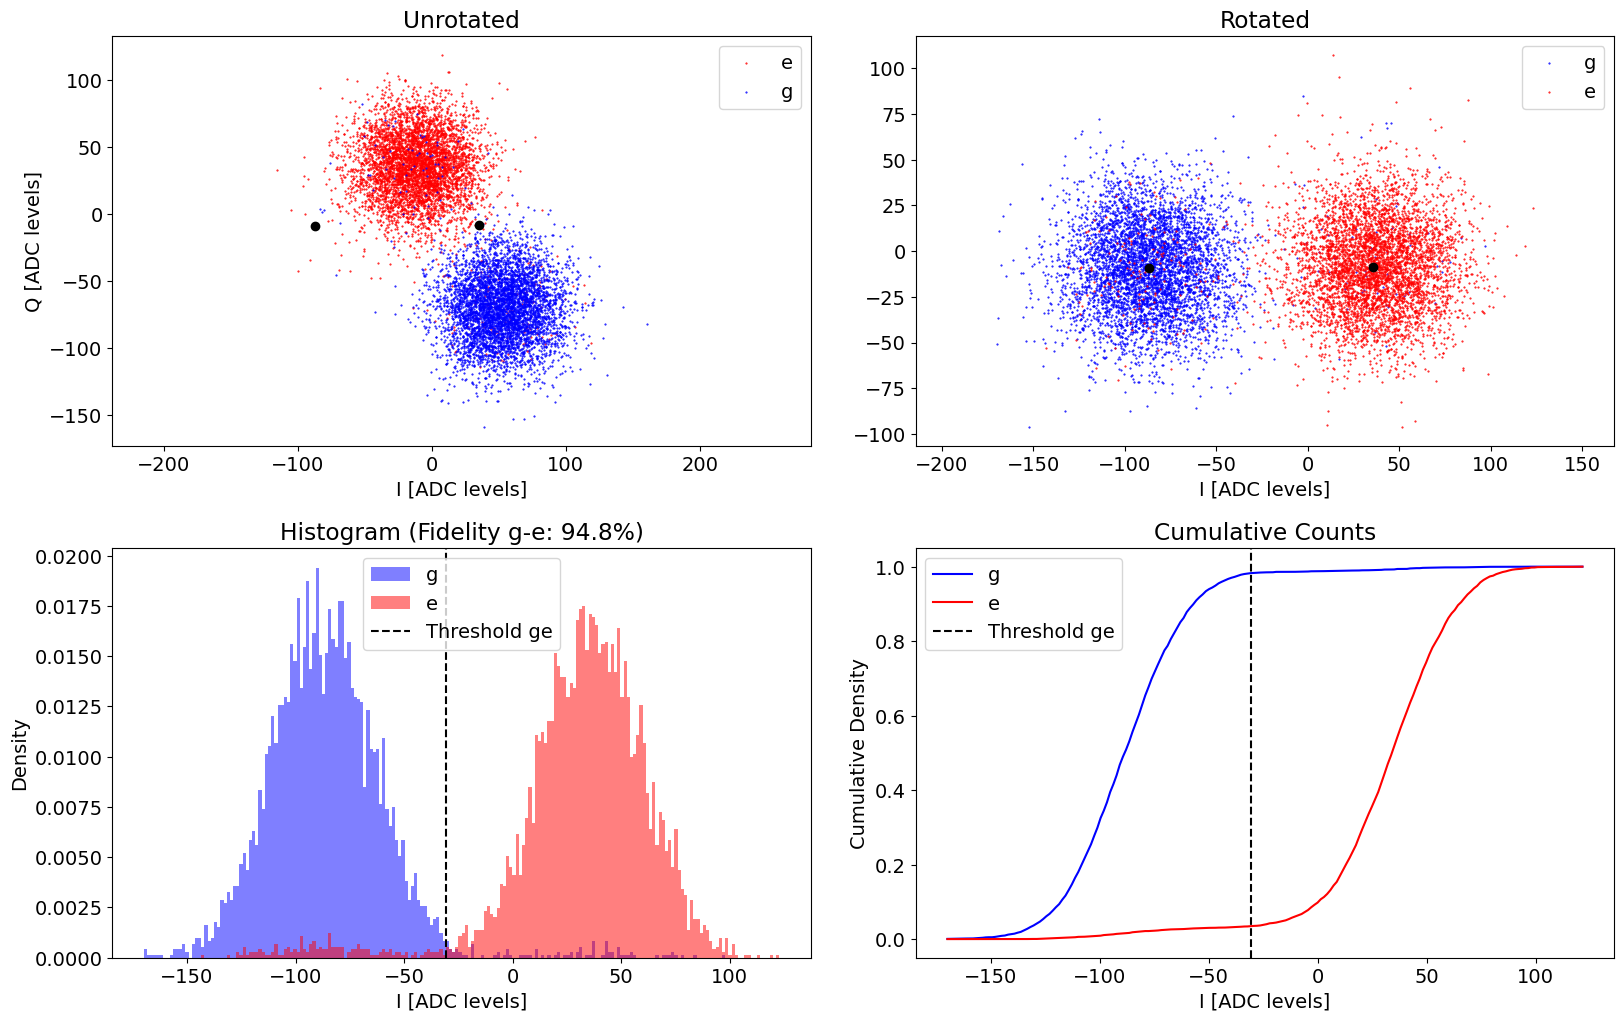

Plot saved to D:\experiments\260203_qsim\plots\2026-02-03_23-18-29_histogram.png
Plot reference appended to D:\experiments\260203_qsim\logs\2026-02-03.md
ge fidelity (%): 94.78
rotation angle (deg): -120.64736523718805
threshold ge: -30.77155692641449


In [5]:
ss.display(station)

In [ ]:
prepulse=False 
if prepulse: 
    postproc = None
else:
    postproc = singleshot_postproc

single_shot_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.single_qubit.single_shot.HistogramExperiment,
    default_expt_cfg = singleshot_defaults,
    postprocessor = singleshot_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)


single_shot = single_shot_runner.execute(
        go_kwargs=dict(analyze=False, display=False),
        check_f=False,
        active_reset=False, # on recalibration of readout, turn off active reset because it will be wrong for selecting when to apply the qubit pulse
        relax_delay=2000,
        pre_sweep_pulse=prepulse_seq,
        prepulse=prepulse,
        gate_based=False,
    )

In [ ]:
station.preview_config_update()

In [ ]:
station.snapshot_hardware_config(update_main=True)

In [ ]:
single_shot.display(station=None)

In [ ]:
single_shot.display(station)

## Photon Number Resolved  Spectroscopy

This is used to check that the fock states are well prepared before we do the tomography

In [ ]:
photon_number_spectro_defaults = AttrDict(dict(
    start=3560, 
    step=0.1,
    expts=200,
    reps=2000,
    rounds=1,
    length=1,
    gain=400,
    sigma=0.1,
    qubits=[0],
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,
))

photon_number_spectro_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment,
    default_expt_cfg=photon_number_spectro_defaults,
    job_client=client,
    use_queue=USE_QUEUE,
    # use_queue=False,
)

In [ ]:
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=1)
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
print(f"pre_sweep_pulse: {pre_sweep_pulse}")

In [ ]:
span = 5
expt = 100
step = span / expt
start = station.hardware_cfg.device.qubit.f_ge[0] - span*0.9
length = 15
gain=25

if tomo_expts_to_run['photon_number_spectro']:
    photon_number_spectro = photon_number_spectro_runner.execute(
        go_kwargs=dict(analyze=True, display=True, save=True),
        pre_sweep_pulse=pre_sweep_pulse,
        prepulse=True,
        gate_based=False,
        start=start,
        length=length,
        sigma=1.,
        gain=gain,
        step=step,
        expts=expt,
        relax_delay=500,
    )

In [ ]:
if tomo_expts_to_run['photon_number_spectro']:
    if USE_QUEUE:
        photon_number_spectro.display()

## Parity Delay

In [ ]:
parity_delay_defaults = AttrDict(dict(
    start=0.01,
    step=0.05,
    expts=50,
    reps=250,
    rounds=1,
    qubits=[0],
    parity_fast=True,
    normalize=False,
    active_reset=False,
    man_reset=True,
    gate_based=False,
    storage_reset=True,
    man_mode_no=1,
    relax_delay=2500, 
    param_to_calib='length', # length or ac_stark_shift 
    shift_sign=1, # 1 or -1 for ac stark shift direction
    ))


def parity_delay_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    if 'param_to_calib' in expt_cfg and expt_cfg.param_to_calib =='ac_stark_shift':
        expt_cfg.prepulse = False
        expt_cfg.pre_sweep_pulse = []
    elif 'param_to_calib' in expt_cfg and expt_cfg.param_to_calib =='length':
        expt_cfg.prepulse = True
        pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=expt_cfg.man_mode_no, photon_no=1)
        pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
        expt_cfg.pre_sweep_pulse = pre_sweep_pulse
    return expt_cfg

def parity_delay_postproc(station, expt):
    from fitting.fit_display_classes import LengthRabiFitting
    # Analyze the data
    length_rabi_analysis = LengthRabiFitting(expt.data, config = expt.cfg)
    length_rabi_analysis.analyze(fitparams = [100, 0.1, 0, None, None, None])
    length_rabi_analysis.display(title_str='Length Rabi General F0g1')
    expt_cfg = expt.cfg.expt
    man_mode_no = expt_cfg.man_mode_no
    shift_sign = expt_cfg.shift_sign


    if expt_cfg.param_to_calib == 'length':
        delay = length_rabi_analysis.results['pi_length']
        print(f'Fitted revival time: {delay} us')
        old_delay = station.hardware_cfg.device.manipulate.revival_time[man_mode_no - 1]
        station.hardware_cfg.device.manipulate.revival_time[man_mode_no - 1] = delay
        print(f'Updated revival time for mode {man_mode_no}: {old_delay} -> {station.hardware_cfg.device.manipulate.revival_time[man_mode_no - 1]}')

    elif expt_cfg.param_to_calib == 'ac_stark_shift': 
        freq = length_rabi_analysis.data['fit_avgi'][1]
        print(f'Fitted ac Stark shift: {freq} MHz')
        old_freq = station.hardware_cfg.device.manipulate.revival_stark_shift[man_mode_no - 1]
        station.hardware_cfg.device.manipulate.revival_stark_shift[man_mode_no - 1] += shift_sign * freq
        print(f'Updated ac Stark shift for mode {man_mode_no}: {old_freq} -> {station.hardware_cfg.device.manipulate.revival_stark_shift[man_mode_no - 1]}')

    


### Calibrate first the AC stark shift

Manipulate in 0, qubit should not rotate

In [ ]:
parity_delay_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityDelayExperiment,
    default_expt_cfg=parity_delay_defaults,
    postprocessor=parity_delay_postproc,
    preprocessor=parity_delay_preproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

parity_delay_ac_stark = parity_delay_runner.execute(
    param_to_calib='ac_stark_shift', 
    go_kwargs=dict(analyze=False, display=False),
    step=0.2,
    expts=100,
    reps=100,
    shift_sign=-1,
)

Confirming the correction is in the right direction

In [ ]:
parity_delay_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityDelayExperiment,
    default_expt_cfg=parity_delay_defaults,
    preprocessor=parity_delay_preproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

parity_delay_ac_stark = parity_delay_runner.execute(
    param_to_calib='ac_stark_shift', 
    go_kwargs=dict(analyze=False, display=False),
    step=0.2,
    expts=100,
    reps=100,
    shift_sign=-1,
)

In [ ]:
parity_delay_ac_stark.display(fit=False)

### Now parity length after the AC stark shift is calibrated

In [ ]:
parity_delay_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityDelayExperiment,
    default_expt_cfg=parity_delay_defaults,
    postprocessor=parity_delay_postproc,
    preprocessor=parity_delay_preproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

parity_delay_ac_stark = parity_delay_runner.execute(
    param_to_calib='length', 
    go_kwargs=dict(analyze=False, display=False),
    step=0.04,
    expts=100,
    reps=200,
)

## Manipulate Parity Spectroscopy

In [ ]:
parity_freq_defaults = AttrDict(dict(
    start=4960,
    stop=5020,
    step=0.60,
    reps=500,
    rounds=1,
    qubits=[0],
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=20,
    man_mode_no=1,
    displace=(True, 0.1, 1000),
    const_pulse=(False, 1),
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500,
))

def parity_freq_postproc(station, expt):
    from fitting.fit_display_classes import Spectroscopy
    spec = Spectroscopy(expt.data, config=expt.cfg)
    spec.analyze()
    spec.display(title='Parity Frequency Experiment')

    expt_cfg = expt.cfg.expt
    man_mode_no = expt_cfg.man_mode_no
    fitted_freq = spec.data['fit_avgi'][2]
    old_freq = station.hardware_cfg.device.manipulate.f_ge[man_mode_no - 1]
    station.hardware_cfg.device.manipulate.f_ge[man_mode_no - 1] = fitted_freq
    print(f'Updated manipulate f_ge for mode {man_mode_no} from {old_freq} to {fitted_freq}')


parity_freq_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityFreqExperiment,
    default_expt_cfg=parity_freq_defaults,
    postprocessor=parity_freq_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)


In [ ]:
parity_freq = parity_freq_runner.execute(
    go_kwargs=dict(analyze=False, display=False),
)

## Manipulate Ramsey (to finetune frequency)
- This will use displace pulse instead do qubit pi/2 to calibrate; we want fine calibration of manipulate frequency not some fast way of extracting T2 time or finding stark shift on f0g1 transition
- Make sure displacements are small $(\alpha \approx 0.2)$
- Somehow i don't get full contrast, like the lowst i,q value dont correspond to g 




In [ ]:
cavity_ramsey_defaults = AttrDict(dict(
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=200,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    reps=100,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    prep_e_first = True,
    relax_delay=2500      # relax delay
))

def cavity_ramsey_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    expt_cfg.man_idx = expt_cfg.man_mode_no - 1

    if expt_cfg.user_defined_pulse is None:
        expt_cfg.user_defined_pulse = [True, station.hardware_cfg.device.manipulate.f_ge[expt_cfg.man_mode_no-1], 10, station.hardware_cfg.device.manipulate.displace_sigma[expt_cfg.man_mode_no-1], 0, 4]

    if expt_cfg.man_ramsey is None:
        expt_cfg.man_ramsey = [False, expt_cfg.man_mode_no -1]
    if expt_cfg.custom_coupler_pulse is None:
        expt_cfg.custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if expt_cfg.pre_sweep_pulse is None:
        expt_cfg.pre_sweep_pulse = []
    if expt_cfg.post_sweep_pulse is None:
        expt_cfg.post_sweep_pulse = []
    # do we need to set the relax delay here?
    return expt_cfg

def cavity_ramsey_postproc(station, expt):

    from fitting.fit_display_classes import RamseyFitting
    ramsey_analysis = RamseyFitting(expt.data, config=expt.cfg)
    delta_f = min(ramsey_analysis.data['f_adjust_ramsey_avgi'])

    expt_cfg = expt.cfg.expt
    man_mode_no = expt_cfg.man_mode_no
    old_freq = station.hardware_cfg.device.manipulate.f_ge[man_mode_no - 1]
    station.hardware_cfg.device.manipulate.f_ge[man_mode_no - 1] = old_freq + delta_f
    print(f'Updated manipulate f_ge for mode {man_mode_no} from {old_freq} to {station.hardware_cfg.device.manipulate.f_ge[man_mode_no - 1]}')

cavity_ramsey_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.t2_cavity.CavityRamseyExperiment,
    default_expt_cfg=cavity_ramsey_defaults,
    preprocessor=cavity_ramsey_preproc,
    postprocessor=cavity_ramsey_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

In [ ]:
station.hardware_cfg.device.manipulate.f_ge[0]=4979.614305651117

cavity_ramsey = cavity_ramsey_runner.execute(
    ramsey_freq=0.5,
    step = 0.1,
    expts = 100,
    reps = 500,
    prep_e_first = False,
    user_defined_pulse=[True, station.hardware_cfg.device.manipulate.f_ge[0], 2000, 
                                station.hardware_cfg.device.manipulate.displace_sigma[0],
                                  0, 4],
)

In [ ]:
if USE_QUEUE:
    cavity_ramsey.display()

## Gain to alpha calibration

will do tomography on the vacuum state

$$
W_\alpha(\ket{0} \bra{0}) = \frac 2\pi e^{-2|\alpha|^2}
$$

In [ ]:
do_parity_gain_defaults = AttrDict(dict(
    start=0,
    step=100,
    expts=40,
    reps=250,
    rounds=1,
    qubit=0,
    qubits=[0],
    normalize=False,
    single_shot=False,
    singleshot_reps=1000,
    singleshot_active_reset=False,
    singleshot_man_reset=True,
    singleshot_storage_reset=True,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    span=1000,
    prep_e=False,
    manipulate=1,
    displace=(True, 0.05), # [enable, sigma] (gaussian length is 4sigma)
    const_pulse=(False, 1), # [enable, length]
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500, 
    pulse_correction=False,
    parity_fast=True,
    scaling_amplitude=True,
    plot_IQ=True,
    man_mode_no=1,
))


def parity_gain_postproc(station, expt):
    expt_cfg = expt.cfg.expt
    scaling_amplitude = expt_cfg.scaling_amplitude
    man_mode_no = expt_cfg.man_mode_no
    expt.analyze(scale=scaling_amplitude, plot=False) # need to fix this (opens a plot that need to be closed on the server side also the scaling is no longer passed correctly for some reason)
    if expt_cfg.plot_IQ:
        i_data = expt.data['idata']
        q_data = expt.data['qdata']
        fig, ax = plt.subplots(1,1, figsize=(6,6))
        ax.scatter(i_data, q_data, s=1, alpha=0.5)
        ax.set_xlabel('I')
        ax.set_ylabel('Q')
        ax.set_title('IQ Scatter Plot')
        plt.show()
    gain_to_alpha = expt.data['gain_to_alpha']
    old_gain_to_alpha = station.hardware_cfg.device.manipulate.gain_to_alpha[expt_cfg.man_mode_no - 1]
    print(f'Gain to alpha for mode {expt_cfg.man_mode_no} : {old_gain_to_alpha} -> {gain_to_alpha}')
    station.hardware_cfg.device.manipulate.gain_to_alpha[man_mode_no - 1] = gain_to_alpha
    if scaling_amplitude:
        scale = expt.data['scale']
        old_scale = station.hardware_cfg.device.manipulate.alpha_scale[man_mode_no - 1]
        station.hardware_cfg.device.manipulate.alpha_scale[man_mode_no - 1] = scale
        print(f'Scaling amplitude for mode {man_mode_no} : {old_scale} -> {scale}')




In [ ]:
parity_gain_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.parity_gain.ParityGainExperiment,
    default_expt_cfg=do_parity_gain_defaults,
    postprocessor=parity_gain_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

parity_gain_expt = parity_gain_runner.execute(
    pulse_correction=True,
    reps=250,
    step=250,
    go_kwargs=dict(analyze=False, display=False),
    )


In [ ]:
if USE_QUEUE: 
    parity_gain_expt.analyze(scale=True, plot=True)

In [ ]:
parity_gain_expt.data.keys()

In [ ]:
station.hardware_cfg.device.manipulate.gain_to_alpha[0] = parity_gain_expt.data['gain_to_alpha']
station.hardware_cfg.device.manipulate.alpha_scale[0] = parity_gain_expt.data['scale']

In [ ]:
station.snapshot_hardware_config(update_main=True)

## Cavity Ramsey versus gain 

This this to find out $\chi$, $\chi'$, $\Delta$ and $K_c$

In [ ]:
cavity_ramsey_sweep_defaults = AttrDict(dict(
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=200,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    gain_start = 1000,  # start gain
    gain_step = 1000,      # step size for gain
    gain_expts = 5,        # number of experiments for gain
    reps=100,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,            
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    relax_delay=2500,      # relax delay
    do_g_and_e=False, # do e-f first
))

def cavity_ramsey_sweep_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    man_mode_no = expt_cfg.man_mode_no

    if expt_cfg.user_defined_pulse is None:
        expt_cfg.user_defined_pulse = [True, station.hardware_cfg.device.manipulate.f_ge[man_mode_no-1], 1000, station.hardware_cfg.device.manipulate.displace_sigma[man_mode_no-1], 0, 4]

    if expt_cfg.man_ramsey is None:
        expt_cfg.man_ramsey = [False, man_mode_no -1]
    if expt_cfg.custom_coupler_pulse is None:
        expt_cfg.custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if expt_cfg.pre_sweep_pulse is None:
        expt_cfg.pre_sweep_pulse = []
    if expt_cfg.post_sweep_pulse is None:
        expt_cfg.post_sweep_pulse = []

    return expt_cfg

cavity_ramsey_sweep_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.t2_cavity.CavityRamseyGainSweepExperiment,
    default_expt_cfg=cavity_ramsey_sweep_defaults,
    preprocessor=cavity_ramsey_sweep_preproc,
    job_client=client,
    use_queue=USE_QUEUE,
)


In [ ]:

gain_start = 3000//2
gain_stop = 15000//2
gain_step = 1000//2


gain_expts = int((gain_stop - gain_start) / gain_step) + 1
print(f'Gain start: {gain_start}, Gain stop: {gain_stop}, Gain step: {gain_step}, Gain expts: {gain_expts}')

In [ ]:
cavity_ramsey_sweep = cavity_ramsey_sweep_runner.execute(
    ramsey_freq=0.5,
    step = 0.15,
    expts = 50,
    gain_start=gain_start,  # start gain
    gain_step=gain_step,      # step size for gain
    gain_expts=gain_expts,        # number of experiments for gain
    reps = 1,
    do_g_and_e=True,
    go_kwargs=dict(save=False, analyze=False, display=False), 
)


In [ ]:
# cavity_ramsey_sweep.analyze(debug=True)
cavity_ramsey_sweep.analyze(track_peaks=True, fit_indices_g=[0,1,2,3,4,5,6],
                            fit_indices_e=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                             debug=False)
cavity_ramsey_sweep.display(save_fig=False)

In [ ]:
delta_g = cavity_ramsey_sweep.data['detuning_g']
print(f"Fitted delta_g: {delta_g} MHz")
old_f_ge = station.hardware_cfg.device.manipulate.f_ge[0]
print(f"Old f_ge frequency: {old_f_ge} MHz")
station.hardware_cfg.device.manipulate.f_ge[0] -= delta_g
print(f"Updated f_ge frequency: {station.hardware_cfg.device.manipulate.f_ge[0]} MHz")

# expts_base_inst.hardware_cfg.device.manipulate.f_ge[0] -= delta_g
# print(f"Updated f_ge frequency: {expts_base_inst.hardware_cfg.device.manipulate.f_ge[0]} MHz")

## Cavity T1

This is to find out $\kappa$

In [ ]:
t1_manipulate_defaults = AttrDict(dict(
    start = 0,
    step = 8,
    expts = 120,
    reps = 500,
    rounds=1,
    man_mode_no=1,
    f0g1_param=None,
    cavity_prepulse=[False, 300, 1.5],
    f0g1_prep=True,
    resolved_pi=False,
    qubit=0,
    normalize=False,
))


def t1_manipulate_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    
    if expt_cfg.f0g1_param is None:
        pulse_param = station.hardware_cfg.device.multiphoton.pi['fn-gn+1']
        expt_cfg.f0g1_param = [pulse_param['frequency'][0],
                               pulse_param['gain'][0],
                                 pulse_param['length'][0], 
                                 pulse_param['sigma'][0],
        ]

    expt_cfg.cavity = expt_cfg.man_mode_no

    return expt_cfg


t1_manipulate_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.t1_cavity.T1CavityExperiment,
    default_expt_cfg=t1_manipulate_defaults,
    preprocessor=t1_manipulate_preproc,
    job_client=client,
    use_queue=USE_QUEUE,
)




In [ ]:
t1_manipulate = t1_manipulate_runner.execute()

## Cavity T2 

In [ ]:
t2_cavity_defaults = AttrDict(dict(
    start=0.01,
    step=0.02*50,
    expts=200,
    ramsey_freq=-5.55,
    # ramsey_freq=3.37,
    reps=250,
    rounds=1,
    qubits=[0],
    checkEF=False,
    f0g1_cavity=0,
    init_gf=False,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    user_defined_pulse=[False, None, None, None, None,0],
    parity_meas=False,
    man_mode_no=1,
    storage_ramsey=[False, 2, True],
    man_ramsey=[True, 1],
    coupler_ramsey=False,
    custom_coupler_pulse=[[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]],
    echoes=[False, 1],
    prepulse=True,
    postpulse=True,
    gate_based = True,
    pre_sweep_pulse= [['qubit', 'ge', 'hpi', 0], ['qubit', 'ef', 'pi', 0]],
    post_sweep_pulse=[['qubit', 'ef', 'pi', 0], ['qubit', 'ge', 'hpi', 0]]
))


t2_cavity_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.t2_cavity.CavityRamseyExperiment,
    default_expt_cfg=t2_cavity_defaults,
    job_client=client,
    use_queue=USE_QUEUE,
)


### T2 ramsey

In [ ]:
t2_cavity = t2_cavity_runner.execute()

In [ ]:
t2_cavity.display()

### T2 echo

In [ ]:
t2_cavity = t2_cavity_runner.execute(
    echoes=[True, 1],
    ramsey_freq=3.20,
)

# Save Config

In [ ]:
station.update_all_station_snapshots(update_main=True, updated_by=user)

# Wigner Tomography

## Generate Optimal Displacements 

In [ ]:
from fitting.wigner import OptimalDisplacementGeneration
n_photon = 6 # maximum photon number to consider
n_disps = 200 # number of displacements to use in the optimization
opt_alphas = OptimalDisplacementGeneration(FD = n_photon, n_disps=n_disps)
return_dict = opt_alphas.optimize(save_dir = station.experiment_path)


In [ ]:
wigner_1mode_defaults = AttrDict(dict(
    displace_length=0.05,
    displacement_path=None,
    prepulse=False,
    pre_sweep_pulse=[],
    pre_gate_sweep_pulse=[],
    reps = 1000,
    qubits=[0],
    gate_based=True,
    pulse_correction=False,
    relax_delay=2500,
    post_select_pre_pulse=False,
    opt_pulse=None,
    IQ_table=None,
    active_reset=False,
    parity_fast=True,
))


wigner_1mode_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.qubit_cavity.single_mode_wigner_tomography.WignerTomography1ModeExperiment,
    default_expt_cfg=wigner_1mode_defaults,
    job_client=client,
    use_queue=USE_QUEUE,
)


# def do_wigner_tomography_1mode(
#     config_thisrun,
#     expt_path,
#     config_path,
#     displace_length=0.05,
#     displacement_path=None,
#     prepulse=False,
#     pre_sweep_pulse=[],
#     pre_gate_sweep_pulse=[],
#     reps = 1000,
#     qubits=[0],
#     gate_based=True,
#     pulse_correction=False,
#     relax_delay=2500,
#     post_select_pre_pulse=False,
#     opt_pulse=None,
#     IQ_table=None,
#     active_reset=False,
#     parity_fast=False,
# ):
#     """
#     Run the Wigner Tomography 1 Mode Experiment with configurable parameters.
#     """
#     expt_cfg = {
#         'displace_length': displace_length,
#         'displacement_path': displacement_path,
#         'reps': reps,
#         'rounds': 1,
#         'prepulse': prepulse,
#         'pre_sweep_pulse': pre_sweep_pulse,
#         'pre_gate_sweep_pulse': pre_gate_sweep_pulse if pre_gate_sweep_pulse is not None else [],
#         'qubits': qubits,
#         'pulse_correction': pulse_correction,
#         'post_select_pre_pulse': post_select_pre_pulse,
#         'opt_pulse': opt_pulse, 
#         'IQ_table': IQ_table,
#         'active_reset': active_reset,
#         'parity_fast': parity_fast,
#     }




#     wigner_exp = expts_base_inst.meas.qubit_cavity.single_mode_wigner_tomography.WignerTomography1ModeExperiment(
#         soccfg=expts_base_inst.soc, path=expt_path, prefix='WignerTomography1ModeExperiment', config_file=config_path
#     )
#     wigner_exp.cfg = AttrDict(deepcopy(hardware_cfg))
#     wigner_exp.cfg.expt = expt_cfg
#     wigner_exp.cfg.expt.gate_based = gate_based  # Set gate_based to False for Wigner tomography
#     wigner_exp.cfg.device.readout.relax_delay = [relax_delay]
#     # wigner_exp.cfg.device.readout.phase = 90.0  # Set readout phase to 0.0

#     wigner_exp.go(analyze=True, display=False, progress=True, save=False)
#     return wigner_exp

# print(expts_base_inst)
# # print(wigner_exp)


# def do_wigner_tomography_1mode_optimal(
#     config_thisrun,
#     expt_path,
#     config_path,
#     pulse_to_test,
#     nb_plot = 3, 
#     displace_length=0.05,
#     displacement_path=None,
#     prepulse=False,
#     pre_sweep_pulse=None,
#     pre_gate_sweep_pulse=None,
#     reps = 1000,
#     qubits=[0],
#     gate_based=True,
#     pulse_correction=False,
#     relax_delay=2500,
#     post_select_pre_pulse=False,
#     opt_pulse=None,
#     IQ_table=None,
#     active_reset=False,
#     parity_fast=False,
# ):
    

#     expt_cfg = {
#         'displace_length': displace_length,
#         'displacement_path': displacement_path,
#         'reps': reps,
#         'rounds': 1,
#         'prepulse': prepulse,
#         'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else [],
#         'pre_gate_sweep_pulse': pre_gate_sweep_pulse if pre_gate_sweep_pulse is not None else [],
#         'qubits': qubits,
#         'pulse_correction': pulse_correction,
#         'post_select_pre_pulse': post_select_pre_pulse,
#         'opt_pulse': opt_pulse, 
#         'IQ_table': IQ_table,
#         'pulse_to_test': pulse_to_test,  # Add pulse_to_test to the configuration   
#         'nb_plot': nb_plot,  # Number of plots to generate
#         'active_reset': active_reset,
#         'parity_fast': parity_fast,
#     }

#     wigner_exp = expts_base_inst.meas.qubit_cavity.single_mode_wigner_tomography.WignerTomographyOptimalPulseExperiment(
#         soccfg=expts_base_inst.soc, path=expt_path, prefix='WignerTomographyOptimalPulseExperiment', config_file=config_path
#     )
#     wigner_exp.cfg = AttrDict(deepcopy(hardware_cfg))
#     wigner_exp.cfg.expt = expt_cfg
#     wigner_exp.cfg.expt.gate_based = gate_based
#     wigner_exp.cfg.device.readout.relax_delay = [relax_delay]
#     # wigner_exp.cfg.device.readout.phase = 90.0  # Set readout phase to 0.0

#     wigner_exp.go(analyze=True, display=False, progress=True, save=True)
#     return wigner_exp
        

## Wigner Tomography

### Sidebands

In [ ]:
photon_list_pre = [1]
prep_man_pi = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=photon_list_pre, broadband=False)
print('prep_man_pi', prep_man_pi)
pulse = mm_base_calib.get_prepulse_creator(prep_man_pi).pulse.tolist()
print('pulse', pulse)

### Optimal control 

In [ ]:
prepulse = [
            # ['optimal_control', 'test', '1', [0, 0]], 
            ['optimal_control', 'fock', '0+4', [0, 0]], 
            ]
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(prepulse[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
expts_base_inst.hardware_cfg.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][0]= gain_qb
expts_base_inst.hardware_cfg.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][1]= gain_cav
expts_base_inst.hardware_cfg.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['frequency'][0]= expts_base_inst.hardware_cfg.device.qubit.f_ge[0]
expts_base_inst.hardware_cfg.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['frequency'][1]= expts_base_inst.hardware_cfg.device.manipulate.f_ge[0]


pulse = mm_base_calib.get_prepulse_creator(prepulse, cfg=expts_base_inst.hardware_cfg).pulse.tolist()

In [ ]:
wigner = wigner_1mode_runner.execute(
    displace_length=0.05,
    reps = 100,
    displacement_path=return_dict['path'], #optimal displacement path
    prepulse=True,
    pre_sweep_pulse=pulse,
    gate_based = False,
    pulse_correction=True,
    relax_delay=2500, 
    post_select_pre_pulse=False,
    active_reset=False,
    go_kwargs=dict(analyze=False, display=False)
)

# wigner = do_wigner_tomography_1mode(
#     config_thisrun=expts_base_inst.hardware_cfg,
#     expt_path=expts_base_inst.expt_path,
#     config_path=expts_base_inst.config_file,
#     displace_length=0.05,
#     reps = 200,
#     displacement_path=return_dict['path'], #optimal displacement path
#     prepulse=False,
#     pre_sweep_pulse=pulse,
#     gate_based = False,
#     pulse_correction=True,
#     # relax_delay=1000, 
#     relax_delay=2500, 
#     post_select_pre_pulse=False,
#     active_reset=False
# )

In [ ]:
cutoff =4
# initial_state = (qt.basis(cutoff, 0)+qt.basis(cutoff, 4)).unit()
initial_state = (qt.basis(cutoff, 1)).unit()
# initial_state = get_hex_GKP(0.377, 2, cutoff)
wigner.analyze(cutoff=cutoff, debug=True)
wigner.display(rotate=True, initial_state=initial_state, mode_state_num=cutoff, station=station, save_fig=True)


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

pe_plus = wigner.data['pe_plus']
pe_minus = wigner.data['pe_minus']
pe = pe_plus + pe_minus
ax[0].plot(np.abs(wigner.data['alpha']), pe, 'o')
ax[0].plot(np.abs(wigner.data['alpha']), pe_plus, 'o', label='pe_plus')
ax[0].plot(np.abs(wigner.data['alpha']), pe_minus, 'o', label='pe_minus')

parity_plus = wigner.data['parity_plus']
parity_minus = wigner.data['parity_minus']
parity = wigner.data['parity']
ax[1].plot(np.abs(wigner.data['alpha']), 2 / np.pi *parity, 'o')
ax[1].plot(np.abs(wigner.data['alpha']), 2 / np.pi *parity_plus, 'o', label='parity_plus')
ax[1].plot(np.abs(wigner.data['alpha']), 2 / np.pi *parity_minus, 'o', label='parity_minus')

ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Probability')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('Parity')
ax[0].legend()
ax[1].legend()
plt.tight_layout()

In [ ]:
# get GKP states
def get_hex_GKP(Delta,d,N):
    psi_list = [0*qt.basis(N,0) for _ in range(d)]
    e1 = np.sqrt(2*np.pi/d/np.sqrt(3))*(np.sqrt(3)/2-0.5j)
    e2 = np.sqrt(2*np.pi/d/np.sqrt(3))*1j
    for n1 in range(-30,31):
        for n2 in range(-30,31):
            for mu in range(d):
                a1 = e1*(d*n1+mu)
                a2 = e2*n2
                psi_list[mu] += np.exp((a1*np.conj(a2)-np.conj(a1)*a2)/2)*qt.coherent(N,a1+a2,method='analytic')

    psis = [((-Delta**2*qt.num(N)).expm()*psi).unit() for psi in psi_list]
    return psis[0]

In [ ]:
_result = wigner.data 
_result.keys()


In [ ]:
_result['target_state']

In [ ]:
np.savetxt(expts_base_inst.expt_path + "bin_W_fit.txt", _result["W_fit"], fmt="%.6e")
np.savetxt(expts_base_inst.expt_path + "bin_alpha_wigner.txt", _result["alpha_wigner"], fmt="%.6e")
np.savetxt(expts_base_inst.expt_path + "bin_alpha_meas.txt", _result["alpha"], fmt="%.6e")
np.savetxt(expts_base_inst.expt_path + "bin_parity.txt", _result["parity"], fmt="%.6e")
np.savetxt(expts_base_inst.expt_path + "bin_target_state.txt", _result["target_state"], fmt="%.6e")


In [ ]:
# results= wigner.data
# # save results in a npz file
# np.savez_compressed(expts_base_inst.expt_path + 'WignerResults.npz',
#                     rho = results['rho'],
#                     fidelity = results['fidelity'],
#                     target_state = initial_state.full(),
#                     Wigner = results['W_fit'],
#                     alpha_wigner = results['alpha_wigner']
#                     )

# # Define where to save results
save_path = expts_base_inst.expt_path + 'WignerResults.npz'

# Collect data in one dictionary for clarity
save_data = {
    "rho": results["rho"],
    "fidelity": results["fidelity"],
    "target_state": initial_state.full(),
    "Wigner": results["W_fit"],
    "alpha_wigner": results["alpha_wigner"],
}

# Save compressed npz file
np.savez_compressed(save_path, **save_data)

## Process Tomography

In [ ]:
def do_process_tomography_1mode(
    hardware_cfg,
    expt_path,
    config_path,
    displace_length=0.05,
    displacement_path=None,
    reps=250,
    qubits=[0],
    gate_based=True,
    pulse_correction=False,
    relax_delay=2500,
    post_select_pre_pulse=False,
    active_reset=False,
    # ProcessTomography-specific
    cardinal_states=None,  # list of list-of-lists for custom_pulse
    wait_start=0.0,
    wait_step=2.0,
    wait_expts=3,
    wait_list=None,
    repeat_list=None,
    # Optional pulses around wait
    prepulse=False,
    pre_sweep_pulse=None,  # list-of-lists (analog) or gate list if gate_based
    pre_gate_sweep_pulse=None,
    postpulse=None,        # list-of-lists (analog) or gate list if gate_based
    parity_shot=False,
    parity_fast=False,
):
    """
    Run the Process Tomography 1 Mode Experiment following the notebook convention.

    Parameters mirror the Wigner helper (do_wigner_tomography_1mode) and add:
      - cardinal_states: list of prepared states (each as list-of-lists for custom_pulse)
      - wait_*: wait sweep in microseconds
      - prepulse/pre_sweep_pulse/postpulse: optional pulses before/after the wait
    """
    if cardinal_states is None or len(cardinal_states) == 0:
        raise ValueError('cardinal_states must be a non-empty list of custom_pulse sequences')


    expt_cfg = {
    'displace_length': displace_length,
    'displacement_path': displacement_path,
    'reps': reps,
    'rounds': 1,
    'qubits': qubits,
    'pulse_correction': pulse_correction,
    'post_select_pre_pulse': post_select_pre_pulse,
    'active_reset': active_reset,
    # ProcessTomography specific
    'cardinal_states': cardinal_states,
    # Optional pulses
    'prepulse': prepulse if prepulse is not None else [],
    # 'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else [],
    # 'pre_gate_sweep_pulse': pre_gate_sweep_pulse if pre_gate_sweep_pulse is not None else [],
    'postpulse': postpulse if postpulse is not None else [],
    'parity_shot': parity_shot,
    'parity_fast': parity_fast,
    }

    if wait_list is not None: 
        expt_cfg['wait_list'] = wait_list
    elif wait_start is not None:
        expt_cfg['wait_start'] = wait_start
        expt_cfg['wait_step'] = wait_step
        expt_cfg['wait_expts'] = wait_expts
    else: 
        wait_list = [0]
        expt_cfg['wait_list'] = wait_list
    if repeat_list is not None:
        expt_cfg['repeat_list'] = repeat_list
    elif repeat_start: 
        expt_cfg['repeat_start'] = repeat_start
        expt_cfg['repeat_step'] = repeat_step
        expt_cfg['repeat_expts'] = repeat_expts
    else: 
        repeat_list = None 



    # Build the experiment via expts_base_inst path to match notebook style
    try:
        ProcClass = expts_base_inst.meas.qubit_cavity.single_mode_wigner_tomography.ProcessTomographyExperiment
        soc_obj = expts_base_inst.soc
    except NameError:
        raise RuntimeError('expts_base_inst is not defined. Initialize your experiment base instance first.')

    proc_exp = ProcClass(soccfg=soc_obj, path=expt_path, prefix='ProcessTomography1Mode', config_file=config_path)
    try:
        proc_exp.cfg = AttrDict(deepcopy(config_thisrun))
    except NameError:
        # Fallback if AttrDict is not available in this notebook scope
        proc_exp.cfg = deepcopy(config_thisrun)

    proc_exp.cfg.expt = expt_cfg
    proc_exp.cfg.expt.gate_based = gate_based
    # Relax delay in microseconds (list to match device schema)
    try:
        proc_exp.cfg.device.readout.relax_delay = [relax_delay]
    except Exception:
        pass

    proc_exp.go(analyze=False, display=False, progress=True, save=False)
    return proc_exp

In [ ]:
# photon_list_pre = [[0], [0, 1], [0, 1j], [1]]
# state_prep_list = []
# for photon_list in photon_list_pre:
#     prep_man_pi = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=photon_list, broadband=True)
#     pulse = mm_base_calib.get_prepulse_creator(prep_man_pi).pulse.tolist()
#     state_prep_list.append(pulse)


prepulse_seq = [['storage', 'M1-S2', 'pi', 0]]
postpulse_seq = [['storage', 'M1-S2', 'pi', 0]]
prepulse_seq = mm_base_calib.get_prepulse_creator(prepulse_seq).pulse.tolist()
postpulse_seq = mm_base_calib.get_prepulse_creator(postpulse_seq).pulse.tolist()



prep_1 = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[2], broadband=False)
prep_pi = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[0,2j], broadband=False)
prep_p = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[0, 2], broadband=False)
prep_0 = []

# prep_pi = [ 
#     ['qubit', 'ge', 'hpi', 0],
#     ['qubit', 'ef', 'pi', 0],
#     ['multiphoton', 'f0-g1', 'pi', 0],
# ]

# prep_p = [ 
#     ['qubit', 'ge', 'hpi', 90],
#     ['qubit', 'ef', 'pi', 0],
#     ['multiphoton', 'f0-g1', 'pi', 0],
# ]

# prep_1 = [ 
#     ['qubit', 'ge', 'pi', 0],
#     ['qubit', 'ef', 'pi', 0],
#     ['multiphoton', 'f0-g1', 'pi', 0],
# ]

# prep_0 = [

#     ]


state_prep_list = []
# photon_list_pre = [prep_0, prep_1, prep_p, prep_pi]
photon_list_pre = [prep_1]


for photon_list in photon_list_pre:
    pulse = mm_base_calib.get_prepulse_creator(photon_list).pulse.tolist()
    print(pulse)
    state_prep_list.append(pulse)

psi0 = qt.basis(5, 0)
psi1 = qt.basis(5, 2)
psi_p = (psi0 + psi1).unit()
psi_pi = (psi0 + 1j*psi1).unit()
# target_states = [psi0, psi1, psi_p, psi_pi]
target_states = [psi1, psi_p]
analyze_state = [target_states[0]]

### Measure for $|2\rangle$ the lifetime versus parity rep time 

In [ ]:

hstgrm = do_single_shot(config_thisrun=expts_base_inst.config_thisrun,expt_path=expts_base_inst.expt_path,config_path=expts_base_inst.config_file, 
                        reps = 5000, 
                        active_reset=False,
                        prepulse=False,
                        gate_based=False,
                        check_f=False,
                        # pre_sweep_pulse=prepulse_seq,
                        # pre_sweep_pulse=parity_pulse,
                        relax_delay = 2500)

update_single_shot(hstgrm[1], expts_base_inst.config_thisrun)

In [ ]:
time_final = 1000  # in microseconds
wait_time_list = np.array([100, 150, 200, 250])  # in microseconds
# wait_time_list = np.array([40, 60, 100, 150])  # in microseconds
num_repeats = time_final // wait_time_list
print(f'Number of repeats: {num_repeats}')


for i in range(len(num_repeats)):
    repeats = np.arange(num_repeats[i])
    print(repeats)
    
    process_tomography = do_process_tomography_1mode(
        config_thisrun=expts_base_inst.config_thisrun,
        expt_path=expts_base_inst.expt_path,
        config_path=expts_base_inst.config_file,
        displace_length=0.05,
        displacement_path=return_dict['path'], #optimal displacement path
        reps = 600,
        prepulse=prepulse_seq,
        postpulse=postpulse_seq,
        gate_based = False,
        pulse_correction=True,
        relax_delay=2500, 
        post_select_pre_pulse=False,
        cardinal_states=state_prep_list,
        wait_list=[wait_time_list[i]],
        repeat_list=repeats,
        parity_shot=True,
    )
    process_tomography.analyze(target_states=analyze_state)
    process_tomography.save_data()

### Measure for all cardinal states for a given waiting time 

In [ ]:
state_prep_list = []
# photon_list_pre = [prep_0, prep_1, prep_p, prep_pi]
photon_list_pre = [prep_1, prep_p]

for photon_list in photon_list_pre:
    pulse = mm_base_calib.get_prepulse_creator(photon_list).pulse.tolist()
    print(pulse)
    state_prep_list.append(pulse)

time_final = 1500  # in microseconds
wait_time = 200  # in microseconds
num_repeats = time_final // wait_time
repeats = np.arange(0, num_repeats)
print(f'Number of repeats: {num_repeats}')

### first with parity shot

In [ ]:

hstgrm = do_single_shot(config_thisrun=expts_base_inst.config_thisrun,expt_path=expts_base_inst.expt_path,config_path=expts_base_inst.config_file, 
                        reps = 5000, 
                        active_reset=False,
                        prepulse=False,
                        gate_based=False,
                        check_f=False,
                        # pre_sweep_pulse=prepulse_seq,
                        # pre_sweep_pulse=parity_pulse,
                        relax_delay = 2500)

update_single_shot(hstgrm[1], expts_base_inst.config_thisrun)

In [ ]:
process = do_process_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps=800,
    displacement_path=return_dict['path'], #optimal displacement path,  # or e.g., return_dict['path']
    cardinal_states=state_prep_list,
    gate_based=False,
    pulse_correction=True,
    relax_delay=2500,
    post_select_pre_pulse=False,
    # wait_start=0.01,
    # wait_step=60.0,
    # wait_expts=15,
    wait_list=[wait_time],
    repeat_list=repeats,
    prepulse=prepulse_seq,
    postpulse=postpulse_seq,
    parity_shot=True,
    active_reset=False,)

process.analyze(target_states=target_states)
process.save_data()

### then without

In [ ]:

hstgrm = do_single_shot(config_thisrun=expts_base_inst.config_thisrun,expt_path=expts_base_inst.expt_path,config_path=expts_base_inst.config_file, 
                        reps = 5000, 
                        active_reset=False,
                        prepulse=False,
                        gate_based=False,
                        check_f=False,
                        # pre_sweep_pulse=prepulse_seq,
                        # pre_sweep_pulse=parity_pulse,
                        relax_delay = 2500)

update_single_shot(hstgrm[1], expts_base_inst.config_thisrun)

In [ ]:
process = do_process_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps=250,
    displacement_path=return_dict['path'], #optimal displacement path,  # or e.g., return_dict['path']
    cardinal_states=state_prep_list,
    gate_based=False,
    pulse_correction=True,
    relax_delay=2500,
    post_select_pre_pulse=False,
    # wait_start=0.01,
    # wait_step=60.0,
    # wait_expts=15,
    wait_list=[wait_time],
    repeat_list=repeats,
    prepulse=prepulse_seq,
    postpulse=postpulse_seq,
    parity_shot=False,
    active_reset=False,)

process.analyze(target_states=target_states)
process.save_data()

### Now do only with wait time and one repeat 

In [ ]:

hstgrm = do_single_shot(config_thisrun=expts_base_inst.config_thisrun,expt_path=expts_base_inst.expt_path,config_path=expts_base_inst.config_file, 
                        reps = 5000, 
                        active_reset=False,
                        prepulse=False,
                        gate_based=False,
                        check_f=False,
                        # pre_sweep_pulse=prepulse_seq,
                        # pre_sweep_pulse=parity_pulse,
                        relax_delay = 2500)

update_single_shot(hstgrm[1], expts_base_inst.config_thisrun)

In [ ]:
state_prep_list = []
photon_list_pre = [prep_1, prep_p]

for photon_list in photon_list_pre:
    pulse = mm_base_calib.get_prepulse_creator(photon_list).pulse.tolist()
    print(pulse)
    state_prep_list.append(pulse)

In [ ]:
time_final = 1000  # in microseconds
# wait_time_list = np.array([0, 150, 300, 450, 600, 750, 900, 1050])  # in microseconds
wait_time_list = [0]
repeat_list = np.arange(0, 20, 2)
# num_repeats = [1]

    
process_tomography = do_process_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    displacement_path=return_dict['path'], #optimal displacement path
    reps = 300,
    gate_based = False,
    pulse_correction=True,
    relax_delay=2500, 
    post_select_pre_pulse=False,
    cardinal_states=state_prep_list,
    wait_list=wait_time_list,
    prepulse=prepulse_seq,
    postpulse=postpulse_seq,
    repeat_list=repeat_list,
    parity_shot=False,
)
    # process_tomography.analyze(target_states=analyze_state)
    # process_tomography.save_data()

In [ ]:
process_tomography.analyze(target_states=target_states)
process_tomography.save_data()

In [ ]:
process_tomography.display(state_idx=0, wait_idx=0,
                repeat_idx=0, target_state=target_states[0],
                 rotate=True, filtered=False)

### Now same for 1 

In [ ]:
prep_1 = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[1], broadband=False)
prep_pi = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[0,1j], broadband=False)
prep_p = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[0, 1], broadband=False)
prep_0 = []
state_prep_list = []
# photon_list_pre = [prep_0, prep_1, prep_p, prep_pi]
photon_list_pre = [prep_1, prep_p]
for photon_list in photon_list_pre:
    pulse = mm_base_calib.get_prepulse_creator(photon_list).pulse.tolist()
    print(pulse)
    state_prep_list.append(pulse)

time_final = 1000  # in microseconds
# wait_time_list = np.array([0, 150, 300, 450, 600, 750, 900, 1050])  # in microseconds
wait_time_list = [0]
repeat_list = np.arange(0, 20, 2)
# num_repeats = [1]

target_states = [qt.basis(5, 1), (qt.basis(5, 0) + qt.basis(5, 1)).unit()]


In [ ]:
process_tomography = do_process_tomography_1mode(
        config_thisrun=expts_base_inst.config_thisrun,
        expt_path=expts_base_inst.expt_path,
        config_path=expts_base_inst.config_file,
        displace_length=0.05,
        displacement_path=return_dict['path'], #optimal displacement path
        # reps = 250,
        reps = 300,
        gate_based = False,
        pulse_correction=True,
        relax_delay=2500, 
        post_select_pre_pulse=False,
        cardinal_states=state_prep_list,
        wait_list=wait_time_list,
        prepulse=prepulse_seq,
        postpulse=postpulse_seq,
        repeat_list=num_repeats,
        parity_shot=False,
    )

In [ ]:
process_tomography.analyze(target_states=target_states)
process_tomography.save_data()

## Debug optimal control
This is taking one optimal control pulse and measure both the qubit and cavity tomography for several time slices. 

In [ ]:
# prepulse = [['optimal_control', 'test', '2', [0, 0]]]
# gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(prepulse[0])
# print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
# expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][0]= gain_qb
# expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][1]= gain_cav
# prepulse = mm_base_calib.get_prepulse_creator(prepulse, cfg=expts_base_inst.config_thisrun).pulse.tolist()


pulse_to_test = [['optimal_control', 'fock', '2', [0, 0]]]
pulse_conf = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]

# set gain 
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(pulse_to_test[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
# expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= 20000
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= gain_qb
# expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= 20000
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= gain_cav



# import the I, Q, times 
filename = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['filename']
data = np.load(filename, allow_pickle=True)
times = data['times'] * 1e-3
Ic = data['I_c']
Qc = -data['Q_c']
Iq = data['I_q']
Qq = -data['Q_q']
qb_scale = max((np.max(np.abs(Iq)), np.max(np.abs(Qq))))
cav_scale = max((np.max(np.abs(Ic)), np.max(np.abs(Qc))))

if qb_scale !=0: 
    Iq /= qb_scale
    Qq /= qb_scale

if cav_scale !=0: 
    Ic /= cav_scale
    Qc /= cav_scale

t_length = len(times)
nb_plot = 5
# t_step = (times[-1] - times[0]) / nb_plot
t_step = (times[30] - times[0]) / nb_plot
# t_to_plot = np.arange(0, times[-1]+t_step, t_step)
t_to_plot = np.arange(0, 5*t_step, t_step)

# t_to_plot = np.array([times[-1]])
t_to_plot[0] +=0.05

data_tot = []
data.close()


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(times, Ic, label='Cavity I')
ax.scatter(times, Qc, label='Cavity Q')
ax.scatter(times, Iq, label='Qubit I')
ax.scatter(times, Qq, label='Qubit Q')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Normalized Signal')
ax.legend()
# add vertical lines at t_to_plot
for t in t_to_plot:
    ax.axvline(t, color='k', linestyle='--', alpha=0.5)

In [ ]:
for i in range(len(t_to_plot)):

    idx_t = np.argmin(np.abs(times - t_to_plot[i]))
    IQ_table = {
        'I_c': Ic[:idx_t],
        'Q_c': Qc[:idx_t],
        'I_q': Iq[:idx_t],
        'Q_q': Qq[:idx_t],
        'times': times[:idx_t]
    }

    wigner = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 250,
    displacement_path=return_dict['path'], #optimal displacement path
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based = False,
    pulse_correction=True,
    active_reset=False,
    relax_delay=2500, 
    post_select_pre_pulse=True,
    IQ_table=IQ_table,
    opt_pulse=pulse_to_test
    )

    wigner.analyze()
    wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg,
                                      mode_state_num=10, alphas = wigner.data['alpha'])
    results = wigner_analysis.wigner_analysis_results(wigner.data['parity'],
                                                       initial_state=qt.fock(wigner_analysis.m, 0), rotate=False)
    fig = wigner_analysis.plot_wigner_reconstruction_results(results, 
                                                             initial_state=qt.fock(wigner_analysis.m, 0), state_label = '')


    rho = results['rho']
    wigner.data['rho'] = rho
    data_tot.append(wigner.data)

In [ ]:
plot_wigner = True
n_distr = np.zeros((len(data_tot), wigner_analysis.m))
p_vec =np.zeros((len(data_tot), 2))
# for each time slice use the rho to compute the photon number distribution
for i in range(len(data_tot)):
    _n_distr = np.diag(data_tot[i]['rho'])
    n_distr[i, :] = _n_distr
    p_vec[i, 1] = data_tot[i]['pe_postpulse']
    p_vec[i, 0] = 1 - p_vec[i, 1]



# open simulation data
if 'pulse' in filename:
    filename_th = filename.replace('pulse', 'pop_sim\populations')
else:
    filename_th = filename.replace('optimal_control\\', 'optimal_control\\pop_sim\\populations_')
data_th = np.load(filename_th, allow_pickle=True)
n_distr_th = data_th['cavity']
p_vec_th = data_th['qubit'][1, :]
times_th = data_th['times'] * 1e-3
rho_cav_t = data_th['rho_cav_t']

F_vec = np.zeros(len(data_tot))

for i in range(len(data_tot)):
    rho_exp = qt.Qobj(data_tot[i]['rho'])
    cutoff_exp = rho_exp.shape[0]
    cutoff_th = rho_cav_t.shape[1]
    cutoff = min(cutoff_exp, cutoff_th)
    idx_t = np.argmin(np.abs(times_th - t_to_plot[i]))
    rho_th = qt.Qobj(rho_cav_t[:cutoff, :cutoff, idx_t])
    rho_exp = qt.Qobj(rho_exp[:cutoff, :cutoff])
    F_vec[i] = qt.fidelity(rho_exp, rho_th)

    if plot_wigner:
        vmin = -2 / np.pi
        vmax = 2 / np.pi
        alpha_list = data_tot[i]['alpha']
        alpha_max = np.max(np.abs(alpha_list))*1.5
        x_vec = np.linspace(-alpha_max, alpha_max, 150)
        W_exp= qt.wigner(rho_exp, x_vec, x_vec)
        W_th = qt.wigner(rho_th, x_vec, x_vec)
        fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        # ax[0].set_aspect('equal')
        ax[0].pcolormesh(x_vec, x_vec, W_exp, vmin=vmin, vmax=vmax, cmap='RdBu_r')
        ax[0].set_xlabel('Re(α)')
        ax[0].set_ylabel('Im(α)')
        ax[0].set_title(f'Exp at t={t_to_plot[i]:.2f} us')

        # ax[1].set_aspect('equal')
        ax[1].pcolormesh(x_vec, x_vec, W_th, vmin=vmin, vmax=vmax, cmap='RdBu_r')
        ax[1].set_xlabel('Re(α)')
        ax[1].set_ylabel('Im(α)')
        ax[1].set_title(f'Th')
        fig.tight_layout()

        # save the figure the the filemane for pop
        fig.savefig(filename_th.replace('.npz', f'_wigner_{i}.png'), dpi=300)


    


# plot a heatmap of the photon number distribution and qubit

fig1, ax1 = plt.subplots(2, 1, figsize=(6, 6))
cax = ax1[0].imshow(n_distr.T, 
                   aspect='auto', origin='lower', cmap='viridis', 
                   extent=[t_to_plot[0], t_to_plot[-1], 0, n_distr.shape[1]-1])
ax1[0].set_xlabel('Time (us)')
ax1[0].set_ylabel('Photon Number')
ax1[0].set_title('Photon Number Distribution exp/theory')

cax2 = ax1[1].imshow(n_distr_th[:n_distr.T.shape[0], ],
                     aspect='auto', origin='lower', cmap='viridis',
                     extent=[times_th[0], times_th[-1], 0,n_distr.T.shape[0]-1])
ax1[1].set_xlabel('Time (us)')
ax1[1].set_ylabel('Photon Number')
# fig.colorbar(cax, ax=ax[0])
fig1.tight_layout()
# save the figure
fig1.savefig(filename_th.replace('.npz', '_photon_distribution.png'), dpi=300)

fig2, ax2 = plt.subplots(2, 1, figsize=(6, 6))

ax2[0].plot(t_to_plot, p_vec[:, 0], 'o-', label='e',
           color='tab:blue', markersize=4, linewidth=1.2)
ax2[0].plot(t_to_plot, p_vec[:, 1], 'o-', label='g',
           color='tab:red', markersize=4, linewidth=1.2)
ax2[0].plot(times_th, p_vec_th, linestyle='--', color = 'tab:blue')
ax2[0].plot(times_th, 1-p_vec_th, linestyle='--', color='tab:red')
ax2[0].set_xlabel('Time (us)')
ax2[0].set_ylabel('Probability')
ax2[0].set_title('Qubit Probabilities')
ax2[0].legend()

ax2[1].plot(t_to_plot, F_vec, 'o-', color='tab:green', markersize=4, linewidth=1.2)
ax2[1].set_xlabel('Time (us)')
ax2[1].set_ylabel('Fidelity')
ax2[1].set_title('Cavity state')
fig2.tight_layout()
# save the figure
fig2.savefig(filename_th.replace('.npz', '_qubit_fidelity.png'), dpi=300)


In [ ]:
# close all files npz and plt
plt.close('all')
data_th.close()

In [ ]:
# save the data
np.savez(filename_th.replace('.npz', '_data.npz'),
         n_distr=n_distr, p_vec=p_vec, F_vec=F_vec,
         n_distr_th=n_distr_th, p_vec_th=p_vec_th, times=times_th,
         t_to_plot=t_to_plot, data_tot=data_tot)

## CMA-ES solver

In [ ]:
from stable_baselines3 import PPO
from CavityQubitEnv import CavityQubitEnv
import qutip as qt
import numpy as np
import cma 


### Pulse to test 

In [ ]:

pulse_to_test = [['optimal_control', 'fock', '2', [0, 0]]]
pulse_conf = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]

# set gain 
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(pulse_to_test[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= gain_qb
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= gain_cav

# import the I, Q, times 
filename = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['filename']
data = np.load(filename, allow_pickle=True)
times = data['times'] * 1e-3
Ic = data['I_c']
Qc = -data['Q_c']
Iq = data['I_q']
Qq = -data['Q_q']
# qb_scale = max((np.max(np.abs(Iq)), np.max(np.abs(Qq))))
# cav_scale = max((np.max(np.abs(Ic)), np.max(np.abs(Qc))))

# if qb_scale !=0: 
#     Iq /= qb_scale
#     Qq /= qb_scale

# if cav_scale !=0: 
#     Ic /= cav_scale
#     Qc /= cav_scale

t_length = len(times)
nb_plot = 1
t_step = (times[-1] - times[0]) / nb_plot
t_to_plot = np.array([times[-1]])
data.close()


In [ ]:
cutoff_cav = 7
psi_0 = qt.fock(cutoff_cav, 0)  # Initial cavity state |0>
# psi_target = (qt.fock(cutoff_cav, 0)+qt.fock(cutoff_cav, 4)).unit()  # Target cavity state |1>
psi_target = (qt.fock(cutoff_cav, 2)).unit()  # Target cavity state |1>
Kc = 0.009422
Kq = -143
chi = 0.310457
system_params = {
    'cutoff_qubit': 2,
    'cutoff_cavity': cutoff_cav,
    'Kc': Kc,
    'Kq': Kq,
    'chi': chi
}
pulse_IQ = {
    'Ic': Ic,
    'Qc': Qc,
    'Iq': Iq,
    'Qq': Qq,
    'times': times
}

amplitude_bound_qb = max(np.max(np.abs(Iq)), np.max(np.abs(Qq)))*0.2
amplitude_bound_cav = max(np.max(np.abs(Ic)), np.max(np.abs(Qc)))*0.2
amplitude_bounds = [amplitude_bound_qb, amplitude_bound_cav]

fig, ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
ax[0].plot(times, Iq, label='I')
ax[0].plot(times, Qq, label='Q')
ax[0].set_ylabel('qubit')
ax[0].legend()
ax[1].plot(times, Ic, label='I')
ax[1].plot(times, Qc, label='Q')
ax[1].set_ylabel('cavity')
ax[1].set_xlabel('Time')
ax[1].legend()
fig.tight_layout()




In [ ]:
N_points = 25  # number of points of a pulse
nb_sample = None  # number of samples per wigner
n_generations = 100
n_repeat = 4  # number of times to repeat the optimization

env = CavityQubitEnv(
    psi_0=psi_0,
    psi_target=psi_target,
    system_params=system_params,
    pulse_IQ=pulse_IQ, 
    amplitude_bounds=amplitude_bounds,
    N_points=N_points,
    nb_sample=nb_sample
)


dim = env.action_space.shape[0]  # = 4*L
sigma0 = 0.1             # initial standard deviation
x0 = np.zeros(dim)               # initial mean (all zero actions)
# popsize =(4 + int(3 * np.log(dim)))*2
popsize = 5
print(f"popsize={popsize}")

# --- CMA-ES optimizer ---
# Popsize formula: 4 + floor(3*log(dim))
es = cma.CMAEvolutionStrategy(x0, sigma0, {
    "popsize": popsize,
    "bounds": [-1.0, 1.0],  # actions are clipped to [-1,1]
})
fidelity_history = []
logger = es.logger  # attach the default logger

In [ ]:
pulse_IQ_temp = env.generate_IQ_pulse(action)
pulse_IQ_test = env.interpolate_IQ_pulse(pulse_IQ_temp)

In [ ]:
fig , ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
ax[0].plot(pulse_IQ_test['times'], pulse_IQ_test['Iq'], label='I')
ax[0].plot(pulse_IQ_test['times'], pulse_IQ_test['Qq'], label='Q')
ax[0].plot(pulse_IQ['times'], pulse_IQ['Iq'], linestyle='--', label='I original')
ax[0].plot(pulse_IQ['times'], pulse_IQ['Qq'], linestyle='--', label='Q original')
ax[0].set_ylabel('qubit')
ax[0].legend()
ax[1].plot(pulse_IQ_test['times'], pulse_IQ_test['Ic'], label='I')
ax[1].plot(pulse_IQ_test['times'], pulse_IQ_test['Qc'], label='Q')
ax[1].plot(pulse_IQ['times'], pulse_IQ['Ic'], linestyle='--', label='I original')
ax[1].plot(pulse_IQ['times'], pulse_IQ['Qc'], linestyle='--', label='Q original')
ax[1].set_ylabel('cavity')
ax[1].set_xlabel('Time')
ax[1].legend()

In [ ]:
from IPython.display import clear_output
fig, ax = plt.subplots(figsize=(6,4))

# fig1, ax1 = plt.subplots()

for gen in range(n_generations):
    solutions = es.ask()
    rewards = []
    for idx, action in enumerate(solutions):
        vals = []
        pulse_IQ_temp = env.generate_IQ_pulse(action)
        pulse_IQ_test = env.interpolate_IQ_pulse(pulse_IQ_temp)
        gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(pulse_IQ=pulse_IQ_test)
        expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= gain_qb
        expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= gain_cav
        print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
        qb_scale = max(np.max(np.abs(pulse_IQ_test['Iq'])), np.max(np.abs(pulse_IQ_test['Qq'])))
        cav_scale = max(np.max(np.abs(pulse_IQ_test['Ic'])), np.max(np.abs(pulse_IQ_test['Qc'])))
        if qb_scale !=0: 
            pulse_IQ_test['Iq'] /= qb_scale
            pulse_IQ_test['Qq'] /= qb_scale
        if cav_scale !=0:
            pulse_IQ_test['Ic'] /= cav_scale
            pulse_IQ_test['Qc'] /= cav_scale

        IQ_table = {
            'I_c': pulse_IQ_test['Ic'],
            'Q_c': pulse_IQ_test['Qc'],
            'I_q': pulse_IQ_test['Iq'],
            'Q_q': pulse_IQ_test['Qq'],
            'times': pulse_IQ_test['times']
        }

        for r in range(n_repeat):  # repeat the experiment n_repeat times and average the reward
            print(f"  Repeat {r+1}/{n_repeat} for action {idx+1}/{len(solutions)}")

            wigner = do_wigner_tomography_1mode(
            config_thisrun=expts_base_inst.config_thisrun,
            expt_path=expts_base_inst.expt_path,
            config_path=expts_base_inst.config_file,
            displace_length=0.05,
            reps = 150,
            displacement_path=return_dict['path'], #optimal displacement path
            prepulse=False,
            pre_sweep_pulse=None,
            gate_based = False,
            pulse_correction=False,
            relax_delay=2500, 
            # relax_delay=1000,
            # active_reset=True, 
            post_select_pre_pulse=False,
            IQ_table=IQ_table,
            opt_pulse=pulse_to_test
            )

            wigner.analyze()
            wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg,
                                            mode_state_num=cutoff_cav, alphas = wigner.data['alpha'])
            results = wigner_analysis.wigner_analysis_results(wigner.data['parity'],
                                                            initial_state=psi_target, rotate=False)
            # fig1 = wigner_analysis.plot_wigner_reconstruction_results(results, 
                                                                    # initial_state=psi_target, state_label = '')

            fidelity = results['fidelity']
            reward = 1 - fidelity  # reward is 1 - fidelity to minimize
            vals.append(reward)
            fidelity_history.append(fidelity)

        
        rewards.append(np.mean(vals))
        # --- clear notebook cell output ---
        clear_output(wait=True)
        print(f"Generation {gen+1}/{n_generations} - Action {idx+1}/{len(solutions)}")
        print(f"Fidelity: {fidelity:.4f}, Reward: {reward:.4f}")

        # --- redraw plot ---
        ax.clear()
        ax.plot(fidelity_history, marker="o")
        ax.set_title(f"Gen {gen+1}, Action {idx+1}")
        ax.set_xlabel("Action #")
        ax.set_ylabel("Fidelity")
        ylim = ax.get_ylim()
        ax.set_ylim(max(0, ylim[0]*0.9), min(1.1, ylim[1]*1.1))
        plt.grid(True)
        display(fig) 


    es.tell(solutions, rewards)
    es.disp()
    logger.add()      # <-- log this generation
    logger.save()     # <-- save to outcmaes folder



In [ ]:
# Suppose `res` is your CMAEvolutionStrategyResult
res = es.result  # replace with your actual result

# --- 1. Best objective value ---
print("Best solution (xbest):", res.xbest)
print("Best fitness (fbest):", res.fbest)
print("Found at evaluation:", res.evals_best)

# --- 2. Plot standard deviations (uncertainty per parameter) ---
plt.figure(figsize=(6,4))
plt.plot(res.stds, marker='o')
plt.title("Final stds per parameter (uncertainty)")
plt.xlabel("Parameter index")
plt.ylabel("Standard deviation")
plt.grid(True)
plt.show()

# --- 3. Compare xbest vs xfavorite ---
plt.figure(figsize=(6,4))
plt.plot(res.xbest, 'o-', label="xbest (best found)")
plt.plot(res.xfavorite, 'x-', label="xfavorite (distribution mean)")
plt.title("Comparison of xbest vs xfavorite")
plt.xlabel("Parameter index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# save the best pulse
best_action = res.xbest
times = pulse_IQ['times']
pulse_IQ_updated = env.interpolate_IQ_pulse(env.generate_IQ_pulse(best_action)).values()

# save to the pulse folder 

np.savez_compressed(filename.replace('.npz', '_optimized.npz'),
                    times=times*1e3,  # back to us
                    I_c=pulse_IQ_updated['Ic'],
                    Q_c=pulse_IQ_updated['Qc'],
                    I_q=pulse_IQ_updated['Iq'],
                    Q_q=pulse_IQ_updated['Qq']
                    )

## CMA-ES solver filter function 

In [ ]:
from stable_baselines3 import PPO
from CavityQubitEnv import CavityQubitEnv
import qutip as qt
import numpy as np
import cma 
from CavityQubitEnv import PredistortionFilter
import CavityQubitEnv as cav 


### Pulse to test 

In [ ]:

pulse_to_test = [['optimal_control', 'fock', '0+4', [0, 0]]]
pulse_conf = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]

# set gain 
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(pulse_to_test[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= gain_qb
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= gain_cav

# import the I, Q, times 
filename = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['filename']
data = np.load(filename, allow_pickle=True)
times = data['times'] * 1e-3
Ic = data['I_c']
Qc = -data['Q_c']
Iq = data['I_q']
Qq = -data['Q_q']


t_length = len(times)
nb_plot = 1
t_step = (times[-1] - times[0]) / nb_plot
t_to_plot = np.array([times[-1]])
data.close()


In [ ]:
cutoff_cav = 5
psi_0 = qt.fock(cutoff_cav, 0)  # Initial cavity state |0>
# psi_target = (qt.fock(cutoff_cav, 0)+qt.fock(cutoff_cav, 4)).unit()  # Target cavity state |1>
psi_target = (qt.fock(cutoff_cav, 0)+qt.fock(cutoff_cav, 4)).unit()  # Target cavity state |1>
# psi_target = (qt.fock(cutoff_cav, 2)).unit()  # Target cavity state |1>
Kc = 0.009422
Kq = -143
chi = 0.310457
system_params = {
    'cutoff_qubit': 2,
    'cutoff_cavity': cutoff_cav,
    'Kc': Kc,
    'Kq': Kq,
    'chi': chi
}
pulse_IQ = {
    'Ic': Ic,
    'Qc': Qc,
    'Iq': Iq,
    'Qq': Qq,
    'times': times
}

amplitude_bound_qb = max(np.max(np.abs(Iq)), np.max(np.abs(Qq)))*0.2
amplitude_bound_cav = max(np.max(np.abs(Ic)), np.max(np.abs(Qc)))*0.2
amplitude_bounds = [amplitude_bound_qb, amplitude_bound_cav]




In [ ]:
N_points = 150  # number of points of a pulse
nb_sample = None  # number of samples per wigner
n_generations = 100
n_repeat = 1  # number of times to repeat the optimization
N_amp = [2, 2]
N_phase = [1, 2]




env = CavityQubitEnv(
    psi_0=psi_0,
    psi_target=psi_target,
    system_params=system_params,
    pulse_IQ=pulse_IQ, 
    amplitude_bounds=amplitude_bounds,
    N_points=N_points,
    nb_sample=nb_sample,
    n_times = 400
)

# upsample to t_fine
IQ_fine = env.interpolate_IQ_pulse(pulse_IQ)
env.Iq = IQ_fine['Iq']
env.Qq = IQ_fine['Qq']
env.Ic = IQ_fine['Ic']
env.Qc = IQ_fine['Qc']
env.times = IQ_fine['times']

fig, ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
ax[0].plot(env.times, env.Iq, label='I')
ax[0].plot(env.times, env.Qq, label='Q')
ax[0].plot(times, Iq, linestyle='--', label='I original')
ax[0].plot(times, Qq, linestyle='--', label='Q original')
ax[0].set_ylabel('qubit')
ax[0].legend()
ax[1].plot(env.times, env.Ic, label='I')
ax[1].plot(env.times, env.Qc, label='Q')
ax[1].plot(times, Ic, linestyle='--', label='I original')
ax[1].plot(times, Qc, linestyle='--', label='Q original')
ax[1].set_ylabel('cavity')
ax[1].set_xlabel('Time')



# create predistortion filters
filter_qubit = PredistortionFilter(N_amp=N_amp[0], N_phase=N_phase[0])
filter_cavity = PredistortionFilter(N_amp=N_amp[1], N_phase=N_phase[1])


# ------------------------
# Bounds and rescaling functions
# ------------------------
# bounds = [
#     (0.75, 1.25),  # amp_qubit0
#     (0.75, 1.25),  # amp_qubit1
#     (-0.15, 0.15), # phase_qubit0
#     (-0.15, 0.15), # phase_qubit1
#     (0.75, 1.25),  # amp_cavity0
#     (0.75, 1.25),  # amp_cavity1
#     (-0.15, 0.15), # phase_cavity0
#     (-0.15, 0.15), # phase_cavity1
#     (-50e-3, 50e-3)       # t_offset
# ]

# bounds = [
#     (0.75, 1.25),  # amp_qubit0
#     (0.75, 1.25),  # amp_qubit1
#     (0.75, 1.25),  # amp_cavity0
#     (0.75, 1.25),  # amp_cavity1
#     (-0.005, 0.005), # phase_cavity0
#     (-200, 200), # phase_cavity1
# ]

bounds = [
    (0.75, 1.25),  # amp_qubit0
    (-10, 10),  # amp_qubit1
    (-0.15, 0.15), # phase_qubit0
    (0.75, 1.25),  # amp_cavity0
    (-10, 10),  # amp_cavity1
    (-0.15, 0.15), # phase_cavity0
    (-50, 50), # phase_cavity1
#     (-50e-3, 50e-3)       # t_offset
]

# CMA-ES setup
# ------------------------
dim = len(bounds)
# x0 = cav.scale([1, 1, 1, 1, 0, 0], bounds)
x0 = cav.scale([1, 0, 0, 1, 0, 0, 0], bounds)
sigma0 = 0.2
popsize = 4

es = cma.CMAEvolutionStrategy(x0, sigma0, {"popsize": popsize})

fidelity_history = []
fidelity_avg_history = []
logger = es.logger  # attach the default logger

In [ ]:
def objective(x_scaled, env, filter_qubit, filter_cavity, repeats=3):
    """
    CMA-ES objective function using rescaled parameters.
    Minimizes 1 - fidelity.
    """
    # Convert scaled [0,1] parameters to real values
    x = cav.unscale(x_scaled, bounds)
    print(f"Testing parameters: {x}")

    # Split x into filter coefficients and time offset
    # check if it has a length has attr or set to 0 if not
    idx = 0
    if filter_qubit.amp_coeffs is None:
        N_amp_q = 0
    else: 
        N_amp_q = len(filter_qubit.amp_coeffs)
        filter_qubit.amp_coeffs[:] = x[idx:idx+N_amp_q]; idx += N_amp_q

    if filter_qubit.phase_coeffs is None:
        N_phase_q = 0
    else:
        N_phase_q = len(filter_qubit.phase_coeffs)
        filter_qubit.phase_coeffs[:] = x[idx:idx+N_phase_q]; idx += N_phase_q
    if filter_cavity.amp_coeffs is None:
        N_amp_c = 0
    else:
        N_amp_c = len(filter_cavity.amp_coeffs)
        filter_cavity.amp_coeffs[:] = x[idx:idx+N_amp_c]; idx += N_amp_c
    if filter_cavity.phase_coeffs is None:
        N_phase_c = 0
    else:
        N_phase_c = len(filter_cavity.phase_coeffs)
        filter_cavity.phase_coeffs[:] = x[idx:idx+N_phase_c]; idx += N_phase_c

    rewards = []
    # Apply filters
    Iq_f, Qq_f = filter_qubit.apply(env.Iq, env.Qq, env.times*1e3)
    # Ic_f, Qc_f = filter_cavity.apply(env.Ic, env.Qc, env.times*1e3, t_offset=t_offset)
    Ic_f, Qc_f = filter_cavity.apply(env.Ic, env.Qc, env.times*1e3)

    pulse_IQ_test = {
        'Iq': Iq_f,
        'Qq': Qq_f,
        'Ic': Ic_f,
        'Qc': Qc_f,
        'times': env.times
    }
    fig, ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
    ax[0].plot(env.times, Iq_f, label='I filtered')
    ax[0].plot(env.times, Qq_f, label='Q filtered')
    ax[0].plot(env.times, env.Iq, linestyle='--', label='I original')
    ax[0].plot(env.times, env.Qq, linestyle='--', label='Q original')
    ax[0].set_ylabel('qubit')
    ax[0].legend()
    ax[1].plot(env.times, Ic_f, label='I filtered')
    ax[1].plot(env.times, Qc_f, label='Q filtered')
    ax[1].plot(env.times, env.Ic, linestyle='--', label='I original')
    ax[1].plot(env.times, env.Qc, linestyle='--', label='Q original')
    ax[1].set_ylabel('cavity')

    gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(pulse_IQ=pulse_IQ_test)
    print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
    expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= gain_qb
    expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= gain_cav
    qb_scale = max(np.max(np.abs(pulse_IQ_test['Iq'])), np.max(np.abs(pulse_IQ_test['Qq'])))
    cav_scale = max(np.max(np.abs(pulse_IQ_test['Ic'])), np.max(np.abs(pulse_IQ_test['Qc'])))
    if qb_scale !=0:
        pulse_IQ_test['Iq'] /= qb_scale
        pulse_IQ_test['Qq'] /= qb_scale
    if cav_scale !=0:
        pulse_IQ_test['Ic'] /= cav_scale
        pulse_IQ_test['Qc'] /= cav_scale


    IQ_table = {
        'I_c': pulse_IQ_test['Ic'],
        'Q_c': pulse_IQ_test['Qc'],
        'I_q': pulse_IQ_test['Iq'],
        'Q_q': pulse_IQ_test['Qq'],
        'times': pulse_IQ_test['times']
    }
    for _ in range(repeats):
        print(f"  Repeat {_+1}/{repeats} for action {idx+1}/{len(solutions)}")

        wigner = do_wigner_tomography_1mode(
            config_thisrun=expts_base_inst.config_thisrun,
            expt_path=expts_base_inst.expt_path,
            config_path=expts_base_inst.config_file,
            displace_length=0.05,
            reps = 250,
            displacement_path=return_dict['path'], #optimal displacement path
            prepulse=False,
            pre_sweep_pulse=None,
            gate_based = False,
            pulse_correction=True,
            relax_delay=2500, 
            # relax_delay=1000,
            # active_reset=True, 
            post_select_pre_pulse=False,
            IQ_table=IQ_table,
            opt_pulse=pulse_to_test
            )
        idx+=1
        
        wigner.analyze()
        wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg,
                                            mode_state_num=cutoff_cav, alphas = wigner.data['alpha'])
        results = wigner_analysis.wigner_analysis_results(wigner.data['parity'],
                                                        initial_state=psi_target, rotate=False)

        fidelity = results['fidelity']
        print(f"    Fidelity: {fidelity:.4f}")
        reward = 1 - fidelity  # reward is 1 - fidelity to minimize
        fidelity_history.append(fidelity)
        rewards.append(reward)  # CMA-ES minimizes
    fidelity_avg = 1 - np.mean(rewards)
    fidelity_avg_history.append(fidelity_avg)

    return np.mean(rewards)

In [ ]:
from IPython.display import clear_output
fig, ax = plt.subplots(2, 1, figsize=(6,7))
for gen in range(n_generations):

    if gen % 5 == 0:
    # rerun single shot calibration
        hstgrm = do_single_shot(config_thisrun=expts_base_inst.config_thisrun,expt_path=expts_base_inst.expt_path,config_path=expts_base_inst.config_file, 
                        reps = 5000, active_reset=False,
                        prepulse=False,
                        gate_based=False,
                        check_f=False,
                        pre_sweep_pulse=prepulse_seq,
                        relax_delay = 2500)
        hstgrm[1].analyze(plot = False)
        update_single_shot(hstgrm[1], expts_base_inst.config_thisrun)
        print('Single shot done!')

    solutions = es.ask()
    costs = [objective(x, env, filter_qubit, filter_cavity, repeats=n_repeat) for x in solutions]
    es.tell(solutions, costs)
    es.disp()
    logger.add()      # <-- log this generation
    logger.save()     # <-- save to outcmaes folder
    # --- clear notebook cell output ---
    clear_output(wait=True)
    print(f"Generation {gen+1}/{n_generations}")
    # print(f"Fidelity: {fidelity:.4f}, Reward: {reward:.4f}")

     # --- redraw plot ---
    ax[0].clear()
    ax[0].plot(fidelity_history, marker="o")

    ax[0].set_title(f"Gen {gen+1}")
    ax[0].set_xlabel("Action #")
    ax[0].set_ylabel("Fidelity")
    ylim = ax[0].get_ylim()
    ax[0].set_ylim(max(0, ylim[0]*0.9), min(1.1, ylim[1]*1.1))
    ax[1].clear()
    ax[1].plot(fidelity_avg_history, marker="o", color='orange')
    ax[1].set_title(f"Average Fidelity")
    ax[1].set_xlabel("Action #")    
    ax[1].set_ylabel("Fidelity")
    ylim = ax[1].get_ylim()
    ax[1].set_ylim(max(0, ylim[0]*0.9), min(1.1, ylim[1]*1.1))
    plt.grid(True)
    fig.tight_layout()
    display(fig)


        
        
        
        
    

In [ ]:
# Suppose `res` is your CMAEvolutionStrategyResult
res = es.result  # replace with your actual result

# --- 1. Best objective value ---
print("Best solution (xbest):", cav.unscale(res.xbest, bounds))
print("Best fitness (fbest):", res.fbest)
print("Found at evaluation:", res.evals_best)

# --- 2. Plot standard deviations (uncertainty per parameter) ---
plt.figure(figsize=(6,4))
plt.plot(res.stds, marker='o')
plt.title("Final stds per parameter (uncertainty)")
plt.xlabel("Parameter index")
plt.ylabel("Standard deviation")
plt.grid(True)
plt.show()

# --- 3. Compare xbest vs xfavorite ---
plt.figure(figsize=(6,4))
plt.plot(res.xbest, 'o-', label="xbest (best found)")
plt.plot(res.xfavorite, 'x-', label="xfavorite (distribution mean)")
plt.title("Comparison of xbest vs xfavorite")
plt.xlabel("Parameter index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# save the best pulse
best_action = res.xbest

# generate the best pulse

action_real = cav.unscale(best_action, bounds)
print(f"Best parameters (real scale): {action_real}")
# Split x into filter coefficients and time offset
idx = 0
if filter_qubit.amp_coeffs is None:
    N_amp_q = 0
else: 
    N_amp_q = len(filter_qubit.amp_coeffs)
    filter_qubit.amp_coeffs[:] = action_real[idx:idx+N_amp_q]; idx += N_amp_q
if filter_qubit.phase_coeffs is None:
    N_phase_q = 0
else:
    N_phase_q = len(filter_qubit.phase_coeffs)
    filter_qubit.phase_coeffs[:] = action_real[idx:idx+N_phase_q]; idx += N_phase_q
if filter_cavity.amp_coeffs is None:
    N_amp_c = 0
else:
    N_amp_c = len(filter_cavity.amp_coeffs)
    filter_cavity.amp_coeffs[:] = action_real[idx:idx+N_amp_c]; idx += N_amp_c
if filter_cavity.phase_coeffs is None:
    N_phase_c = 0
else:
    N_phase_c = len(filter_cavity.phase_coeffs)
    filter_cavity.phase_coeffs[:] = action_real[idx:idx+N_phase_c]; idx += N_phase_c

# apply filters and save

Iq_f, Qq_f = filter_qubit.apply(env.Iq, env.Qq, env.times*1e3)
Ic_f, Qc_f = filter_cavity.apply(env.Ic, env.Qc, env.times*1e3)
pulse_IQ_updated = {
    'Iq': Iq_f,
    'Qq': Qq_f,
    'Ic': Ic_f,
    'Qc': Qc_f,
    'times': env.times
}

# plot and compare with original
fig, ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
ax[0].plot(env.times, Iq_f, label='I filtered')
ax[0].plot(env.times, Qq_f, label='Q filtered')
ax[0].plot(env.times, env.Iq, linestyle='--', label='I original')
ax[0].plot(env.times, env.Qq, linestyle='--', label='Q original')
ax[0].set_ylabel('qubit')
ax[0].legend()
ax[1].plot(env.times, Ic_f, label='I filtered')
ax[1].plot(env.times, Qc_f, label='Q filtered')
ax[1].plot(env.times, env.Ic, linestyle='--', label='I original')
ax[1].plot(env.times, env.Qc, linestyle='--', label='Q original')
ax[1].set_ylabel('cavity')
ax[1].set_xlabel('Time')
fig.tight_layout()



# # times = pulse_IQ['times']
# # pulse_IQ_updated = env.interpolate_IQ_pulse(env.generate_IQ_pulse(best_action)).values()

# # save to the pulse folder 

np.savez_compressed(filename.replace('.npz', '_optimized.npz'),
                    times=pulse_IQ_updated['times']*1e3, 
                    I_c=pulse_IQ_updated['Ic'],
                    Q_c=-pulse_IQ_updated['Qc'],
                    I_q=pulse_IQ_updated['Iq'],
                    Q_q=-pulse_IQ_updated['Qq']
                    )

## Transduction experiment

### Parameters

In [ ]:
cutoff = 8
eta_vec = np.linspace(0.1, 0.6, 15)
print(eta_vec)
theta_vec = np.arccos(np.sqrt(eta_vec))*2
ratio = theta_vec / np.pi
use_optimal_control = False

phase_corr = [0, 0, -127.27272727272728+10.90909090909091+5.4545454545454675
, -261.8181818181818+32.72727272727273+16.363636363636402]

# define pulses before wigner

prepulse_before = [[], [], [], []]
prepulse_after = [[], [], [], []]
# photon_list_pre = [1]
# prep_man_pi = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=photon_list_pre, broadband=True)
# prep_man_pi.append(['storage', 'M1-S1', 'pi', 0])  # Add a pi pulse on storage after the prepulse
# photon_list = [0, 2]
# prep_man_bis = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=photon_list, broadband=True)
# for _pulse in prep_man_bis:
#     prep_man_pi.append(_pulse)
# print(f'Prepulse: {prep_man_pi}')
# pulse = mm_base_calib.get_prepulse_creator(prep_man_pi).pulse.tolist()

### Prepare fock 1

In [ ]:
fock_list = [1]
prep_fock_1 = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=fock_list, broadband=True)
for _pulse in prep_fock_1:
    for j in range(len(prepulse_before)):
        prepulse_before[j].append(_pulse)
        prepulse_after[j].append(_pulse)

for j in range(len(prepulse_before)):
    prepulse_before[j].append(['storage', 'M1-S3', 'pi', 0])  # Add a pi pulse on storage after the prepulse
    prepulse_after[j].append(['storage', 'M1-S3', 'pi', 0])  # Add a pi pulse on storage after the prepulse

### Prepare the cardinal states

In [ ]:
if not use_optimal_control:
    prep_2 = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[2], broadband=True)
    prep_0_2 = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[0, 2], broadband=True)
    prep_0_2j = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[0, 2j], broadband=True)
    prep_0_2[0][-1] = phase_corr[2]
    prep_0_2j[0][-1] = phase_corr[3]

    for _pulse in prep_2:
        prepulse_before[1].append(_pulse)
        prepulse_after[1].append(_pulse)
    for _pulse in prep_0_2:
        prepulse_before[2].append(_pulse)
        prepulse_after[2].append(_pulse)
    for _pulse in prep_0_2j:
        prepulse_before[3].append(_pulse)
        prepulse_after[3].append(_pulse)
else:
    prepulse_before[1].append(['optimal_control', 'fock', '2', [0, 0]])
    prepulse_after[1].append(['optimal_control', 'fock', '2', [0, 0]])
    prepulse_before[2].append(['optimal_control', 'fock', '0+2', [0, 0]])
    prepulse_after[2].append(['optimal_control', 'fock', '0+2', [0, 0]])
    prepulse_before[3].append(['optimal_control', 'fock', '0+2i', [0, 0]])
    prepulse_after[3].append(['optimal_control', 'fock', '0+2i', [0, 0]])
   

### add the swap we want to test

In [ ]:
for j in range(len(prepulse_before)):
    prepulse_after[j].append(['storage', 'M1-S3', 'pi', 0])  # Add a pi pulse on storage after the prepulse
    

### Measure the tomography before the swap test 

In [ ]:
state_labels = ['0', '2', '0_2', '0_2i']
initial_start_qt = [0 * qt.fock(cutoff, 0) for _ in range(len(state_labels))]
initial_states = [[0], [2], [0, 2], [0, 2j]]
for idx, photon_list in enumerate(initial_states):
    print(f'Initial state: {photon_list}')
    for i in photon_list:
        n = int(np.abs(i))  # photon number
        state = qt.fock(cutoff, n)
        coeff = i/np.abs(i) if np.abs(i) > 0 else 1
        initial_start_qt[idx] += coeff * state
    

In [ ]:
mm_base_calib.get_prepulse_creator(prepulse_before[2], cfg=expts_base_inst.config_thisrun).pulse.tolist()

In [ ]:
# for j in range(len(prepulse_before)):
wigner_data_before = []
for j in range(len(prepulse_before)):
# for j in [0]:
    prepulse = mm_base_calib.get_prepulse_creator(prepulse_before[j], cfg=expts_base_inst.config_thisrun).pulse.tolist()
    print(f'Prepulse {j}: {prepulse_before[j]}')
    wigner = do_wigner_tomography_1mode(
        config_thisrun=expts_base_inst.config_thisrun,
        expt_path=expts_base_inst.expt_path,
        config_path=expts_base_inst.config_file,
        displace_length=0.05,
        reps = 250,
        displacement_path=return_dict['path'], #optimal displacement path
        prepulse=True,
        pre_sweep_pulse=prepulse,
        gate_based = False,
        pulse_correction=True,
        relax_delay=7000, 
        post_select_pre_pulse=False,
    )
    wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg,
                                      mode_state_num=10, alphas = wigner.data['alpha'])
    results = wigner_analysis.wigner_analysis_results(wigner.data['parity'],
                                                       initial_state=initial_start_qt[j], rotate=True)
    # add the the keys of results to wigner.data
    for key in results:
        if key != 'wigner_analysis':
            wigner.data[key] = results[key].full() if isinstance(results[key], qt.Qobj) else results[key]
    
    wigner.save_data()
    fig = wigner_analysis.plot_wigner_reconstruction_results(results, 
                                                             initial_state=initial_start_qt[j],
                                                               state_label = state_labels[j] + ' initial')
    wigner_data_before.append(wigner.data)
    

### For the 4 cardinal states measure the tomography versus eta 

In [ ]:
wigner_data_after = [[], [], [], []]
# for j in tqdm(range(2,len(prepulse_after))):
for j in tqdm(range(0,2)):
    prepulse = mm_base_calib.get_prepulse_creator(prepulse_after[j], cfg=expts_base_inst.config_thisrun).pulse.tolist()
    print(f'Prepulse {j}: {prepulse}')
    pulse_length = prepulse[2][-1]
    for r in range(len(ratio)):
    # update the pulse length 
        prepulse[2][-1] = pulse_length*ratio[r]
        print(prepulse[2][-1])
        wigner = do_wigner_tomography_1mode(
            config_thisrun=expts_base_inst.config_thisrun,
            expt_path=expts_base_inst.expt_path,
            config_path=expts_base_inst.config_file,
            displace_length=0.05,
            reps = 250,
            displacement_path=return_dict['path'], #optimal displacement path
            prepulse=True,
            pre_sweep_pulse=prepulse,
            gate_based = False,
            pulse_correction=True,
            relax_delay=7000, 
            post_select_pre_pulse=False,
        )
        wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg,
                                          mode_state_num=8, alphas = wigner.data['alpha'])
        results = wigner_analysis.wigner_analysis_results(wigner.data['parity'],
                                                           initial_state=initial_start_qt[j], rotate=True)
        # add the the keys of results to wigner.data
        for key in results:
            if key != 'wigner_analysis':
                wigner.data[key] = results[key].full() if isinstance(results[key], qt.Qobj) else results[key]

        wigner.data['pulse_length'] = prepulse[2][-1]
        wigner.data['eta'] = eta_vec[r]
        # wigner.data['state_label'] = np.array([state_labels[j]])
        
        
        wigner.save_data()
        fig = wigner_analysis.plot_wigner_reconstruction_results(results,
                                                                    initial_state=initial_start_qt[j],
                                                                    state_label = state_labels[j] + f' final r={ratio[r]:.2f}')
        wigner_data_after[j].append(wigner.data)
        


## Swap against fidelity

In [ ]:
## Checking code
# stor = 7 #storage number from 1
# fock_n = 5 #fock numbers from 0
# swap_iter = 6 #even swaps from 0
# swaps_plot = [2*i for i in range(swap_iter)]


# for k in range(stor): #storage number
#     fock_dict = {"fock_"+str(fock_n): [] for fock_n in range(fock_n)}

#     for j in range(fock_n): #fock states 0 to 4
#         photon = j
#         fid_results = []
        
#         for i in range(swap_iter): #even no. of swaps from 0 to 10
#             swaps = 2*i
#             fid_results += [swaps+j+k]

#         print(f'Fidelity-swap results for fock ' +str(j) + ' in storage ' + str(k+1) + ':')
#         print(fid_results)
#         print(swaps_plot)
#         fock_dict['fock_'+str(j)].append(fid_results)

#     print(f'Storage {k+1} swap fidelity results:')
#     print(fock_dict)
#     plt.figure(figsize=(10, 6))    
#     for l in range(fock_n):
#         fock_i = fock_dict['fock_'+str(l)][0]
#         plt.plot(swaps_plot, fock_i, marker='o', label='Fock ' + str(fock_n))
#     # plt.plot(indices, fock_0, marker='o', label='Fock 0')
#     plt.xlabel('Number of Swaps')
#     plt.ylabel('Fidelity')
#     plt.title(f'Fidelity vs Number of Swaps for Fock ' + str(j) + ' in Storage ' + str(k+1))
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [ ]:
from fitting.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
import matplotlib.pyplot as plt

stor = 1 #storage number from 1
# fock_n = 5 #fock numbers from 0
swap_iter = 5 #even swaps from 0
swaps_plot = [2*i for i in range(swap_iter)]

prepulse = [
            ['optimal_control', 'test', '2', [0, 0]], 
            ]
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(prepulse[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][0]= gain_qb
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][1]= gain_cav

wigner_swap_fid_data = []

for k in range(stor): #storage number
    fid_results = []
            
    for i in range(swap_iter): #even no. of swaps from 0 to 10
        swaps = 2*i
        prep_man_pi = prepulse
        for s in range(swaps):
            prep_man_pi.append(['storage', 'M1-S'+str(k+1), 'pi', 0])  
        pulse = mm_base_calib.get_prepulse_creator(prep_man_pi, cfg=expts_base_inst.config_thisrun).pulse.tolist()
        print(f'doing ' + str(swaps) + ' swaps for GKP in storage ' + str(k+1))

        wigner = do_wigner_tomography_1mode(
            config_thisrun=expts_base_inst.config_thisrun,
            expt_path=expts_base_inst.expt_path,
            config_path=expts_base_inst.config_file,
            displace_length=0.05,
            reps = 250,
            displacement_path=return_dict['path'],
            prepulse=True,
            pre_sweep_pulse=pulse,
            gate_based = False,
            # relax_delay=8000
            relax_delay=5000,
            pulse_correction=True
        )

        wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg, mode_state_num=10, alphas = wigner.data['alpha'])
        initial_state = get_hex_GKP(0.408,2,wigner_analysis.m)
        # allocated_counts = wigner_analysis.bin_ss_data()
        # p_e = allocated_counts # Probability of measuring the state |e
        # p_g = 1 - allocated_counts  # Probability of measuring the state |g
        results = wigner_analysis.wigner_analysis_results(wigner.data['parity'], initial_state=initial_state, rotate=True)
        print(results['fidelity'])
        fid_results += [results['fidelity']]
        wigner.save_data()
        wigner_swap_fid_data.append(wigner.data)
        fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = f'GKP after {swaps} swaps')
    
    print(f'Fidelity-swap results for GKP in storage ' + str(k+1) + ':')
    print(fid_results)
    print(swaps_plot)

    print(f'Storage {k+1} swap fidelity results:')
    plt.figure(figsize=(10, 6))    
    plt.plot(swaps_plot, fid_results, marker='o', label='GKP')
    plt.xlabel('Number of Swaps')
    plt.ylabel('Fidelity')
    plt.title(f'Fidelity vs Number of Swaps for in Storage ' + str(k+1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # filename = title.replace(' ', '_').replace(':', '') + '.png'
    # self.save_plot(fig, filename=filename)

In [ ]:
plt.plot(swaps_plot, fid_results, marker='o', label='GKP')
plt.xlabel('Number of Swaps')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs Number of Swaps for in Storage ' + str(k+1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from fitting.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
import matplotlib.pyplot as plt

stor = 7 #storage number from 1
fock_n = 5 #fock numbers from 0
swap_iter = 6 #even swaps from 0
swaps_plot = [2*i for i in range(swap_iter)]

for k in range(stor): #storage number
    fock_dict = {"fock_"+str(fock_n): [] for fock_n in range(fock_n)}

    for j in range(fock_n): #fock states 0 to 4
        photon = j
        fid_results = []
        
        for i in range(swap_iter): #even no. of swaps from 0 to 10
            swaps = 2*i
            prep_man_pi = mm_base_calib.prep_man_photon(man_no=1, photon_no=photon)
            for s in range(swaps):
                prep_man_pi.append(['storage', 'M1-S'+str(k+1), 'pi', 0])  


            pulse = mm_base_calib.get_prepulse_creator(prep_man_pi).pulse.tolist()
            print(f'doing ' + str(swaps) + ' swaps for fock ' + str(photon) + ' in storage ' + str(k+1))
            wigner = do_wigner_tomography_1mode(
                config_thisrun=expts_base_inst.config_thisrun,
                expt_path=expts_base_inst.expt_path,
                config_path=expts_base_inst.config_file,
                displace_length=0.05,
                reps = 1000,
                displacement_path=return_dict['path'],
                prepulse=True,
                pre_sweep_pulse=pulse,
                gate_based = False,
                # relax_delay=8000
                relax_delay=5000
            )

            wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg, mode_state_num=10, alphas = wigner.data['alpha'])
            initial_state = (fock(wigner_analysis.m, photon)).unit() 
            allocated_counts = wigner_analysis.bin_ss_data()
            p_e = allocated_counts # Probability of measuring the state |e
            p_g = 1 - allocated_counts  # Probability of measuring the state |g
            plt.plot(np.abs(wigner.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')
            results = wigner_analysis.wigner_analysis_results((p_g-p_e), initial_state=initial_state, rotate=True)
            print(results['fidelity'])
            fid_results += [results['fidelity']]
            

        print(f'Fidelity-swap results for fock ' +str(j) + ' in storage ' + str(k+1) + ':')
        print(fid_results)
        print(swaps_plot)
        fock_dict['fock_'+str(j)].append(fid_results)

    print(f'Storage {k+1} swap fidelity results:')
    print(fock_dict)
    plt.figure(figsize=(10, 6))    
    for l in range(fock_n):
        fock_i = fock_dict['fock_'+str(l)][0]
        plt.plot(swaps_plot, fock_i, marker='o', label='Fock ' + str(l))
    plt.xlabel('Number of Swaps')
    plt.ylabel('Fidelity')
    plt.title(f'Fidelity vs Number of Swaps for in Storage ' + str(k+1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # filename = title.replace(' ', '_').replace(':', '') + '.png'
    # self.save_plot(fig, filename=filename)

## GKP T1

In [ ]:
prepulse = [
            ['optimal_control', 'test', '2', [0, 0]], 
            ]
prep_man_pi = prepulse
prep_man_pi.append(['wait', '700', '', ''])
pulse = mm_base_calib.get_prepulse_creator(prep_man_pi, cfg=expts_base_inst.config_thisrun).pulse.tolist()

print(prep_man_pi)
print(pulse)

In [ ]:
from fitting.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
import matplotlib.pyplot as plt

s = 12
interval = 30
time = interval*np.linspace(1,s,s).astype(int)

prepulse = [
            ['optimal_control', 'test', '2', [0, 0]], 
            ]
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(prepulse[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][0]= gain_qb
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][1]= gain_cav

wigner_gkp_t1_data = []
fid_T1_results = []
        
for t in range(s): 
    prep_man_pi = prepulse
    prep_man_pi.append(['storage', 'M1-S1', 'pi', 0])  
    for r in range(t+1):
        prep_man_pi.append(['wait', str(interval), '', ''])
        print("adding wait of " + str(interval) + " us")
    prep_man_pi.append(['storage', 'M1-S1', 'pi', 0])  

    pulse = mm_base_calib.get_prepulse_creator(prep_man_pi, cfg=expts_base_inst.config_thisrun).pulse.tolist()
    print(f'wating {interval*(t)} us for GKP in storage 1')

    wigner = do_wigner_tomography_1mode(
        config_thisrun=expts_base_inst.config_thisrun,
        expt_path=expts_base_inst.expt_path,
        config_path=expts_base_inst.config_file,
        displace_length=0.05,
        reps = 250,
        displacement_path=return_dict['path'],
        prepulse=True,
        pre_sweep_pulse=pulse,
        gate_based = False,
        # relax_delay=8000
        relax_delay=5000,
        pulse_correction=True
    )

    wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg, mode_state_num=10, alphas = wigner.data['alpha'])
    initial_state = get_hex_GKP(0.408,2,wigner_analysis.m)
    # allocated_counts = wigner_analysis.bin_ss_data()
    # p_e = allocated_counts # Probability of measuring the state |e
    # p_g = 1 - allocated_counts  # Probability of measuring the state |g
    results = wigner_analysis.wigner_analysis_results(wigner.data['parity'], initial_state=initial_state, rotate=True)
    print(results['fidelity'])
    fid_T1_results += [results['fidelity']]
    wigner.save_data()
    wigner_gkp_t1_data.append(wigner.data)
    fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = f'GKP after {interval*(t+1)} us')

print(f'GKP T1 results: ')
print(fid_T1_results)
print(time)
plt.figure(figsize=(10, 6))    
plt.plot(time, fid_T1_results, marker='o', label='GKP')
plt.xlabel('Time (us)')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs Wait time in Storage ')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# filename = title.replace(' ', '_').replace(':', '') + '.png'
# self.save_plot(fig, filename=filename)

In [ ]:
fid_results

In [ ]:
wigner_gkp_t1_data

## Wigner Tomography of |0+2>

In [ ]:
from experiments.MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_02_pulse = []
prep_02_pulse.append(['qubit', 'ge', 'hpi', 0]) # g0 + e0 
prep_02_pulse.append(['qubit', 'ef', 'pi', 0]) # g0 + f0 
prep_02_pulse.append(['qubit', 'ge', 'pi', 0])# e0 + f0
prep_02_pulse.append(['multiphoton', 'f0-g1', 'pi', 0]) # e0 + g1 
prep_02_pulse.append(['multiphoton', 'g0-e0', 'pi', 0]) # g0 + e1
prep_02_pulse.append(['multiphoton', 'e1-f1', 'pi', 0]) # g0 + f1 
prep_02_pulse.append(['multiphoton', 'f1-g2', 'pi', 0]) # g0 + g2
prep_02_pulse
## convert it to low level pulse 
pulse_02 = mm_base_dummy.get_prepulse_creator(prep_02_pulse).pulse.tolist()
pulse_02

## Wigner Tomography of |0> + |1>

### Debugging

##### Histogram Prepulse

In [ ]:
def do_histogram_prepulse_experiment(
    reps=10000,
    qubits=[0],
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    preloaded_pulses=False,
    use_arb_waveform=False,
    expts_base_inst=None,
    expt_path=None,
    config_path=None,
    config_thisrun=None,
    relax_delay=2500
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    expt_cfg = {
        'reps': reps,
        'qubits': qubits,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'preloaded_pulses': preloaded_pulses,
        'use_arb_waveform': use_arb_waveform
    }
    histogram_exp = expts_base_inst.meas.single_qubit.single_shot_prepulse.HistogramPrepulseExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='HistogramPrepulseExperiment', config_file=config_path
    )
    histogram_exp.cfg = AttrDict(deepcopy(config_thisrun))
    histogram_exp.cfg.expt = expt_cfg
    histogram_exp.go(analyze=False, display=False, progress=True, save=True)
    return histogram_exp


In [ ]:
historgam_exp = do_histogram_prepulse_experiment(
    reps=10000,
    qubits=[0],
    expts_base_inst=expts_base_inst,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    config_thisrun=expts_base_inst.config_thisrun,
    prepulse=True,
    gate_based=True,
    pre_sweep_pulse=[['qubit', 'ge', 'hpi', 0]],  # Use the prepulse pulse created above
)

In [ ]:
historgam_exp.data['I'].shape

In [ ]:
from matplotlib import gridspec


# i, q
# plt.plot(wigner_exp_01.data['i0'][0][0], wigner_exp_01.data['q0'][0][0], 'o', markersize=2, color='black')
# Plot histograms along x and y axes

# Get data
x = historgam_exp.data['I']
y = historgam_exp.data['Q']



# Create a figure with gridspec for scatter and histograms
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                       wspace=0.05, hspace=0.05)

ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.plot(x, y, 'o', markersize=2, color='black')
ax_scatter.set_xlabel('i0')
ax_scatter.set_ylabel('q0')

# X histogram
ax_histx.hist(x, bins=40, color='gray')
ax_histx.axis('off')

# Y histogram
ax_histy.hist(y, bins=40, orientation='horizontal', color='gray')
ax_histy.axis('off')

threshold = -314
below_threshold = x < threshold
proportion_below = np.sum(below_threshold) / len(x)
print(f"Proportion of points below threshold {threshold}: {proportion_below:.3f} ({np.sum(below_threshold)}/{len(x)})")

# Plot threshold line and highlight points below threshold
ax_scatter.axvline(threshold, color='red', linestyle='--', label=f'Threshold {threshold}')
ax_scatter.plot(x[below_threshold], y[below_threshold], 'ro', markersize=3, label='Below threshold')
ax_scatter.legend()

plt.show()

In [ ]:
from experiments.MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)

prep_01_pulse = [['qubit', 'ge', 'hpi', 0], # g0 + e0 
['qubit', 'ef', 'pi', 0], # g0 + f0 
['multiphoton', 'f0-g1', 'pi', 0]] # e0 + g1 
## convert it to low level pulse 
pulse_01 = mm_base_dummy.get_prepulse_creator(prep_01_pulse).pulse.tolist()
pulse_01

In [ ]:
# choose alphas along 3 axes 
alpha_list = np.linspace(0, 1, 10) 
phase_across_three_axes = np.array([0, 90, 180])  # in degrees
alphas = []
for phase in phase_across_three_axes:
    alphas.append(alpha_list * np.exp(1j * np.deg2rad(phase)))
alpha_list_full = np.concatenate(alphas)
alpha_list_full
f_path = expts_base_inst.expt_path + '\\alphas.npy'
np.save(f_path, alpha_list_full)


In [ ]:
alpha_list_full

In [ ]:
# Now doing wigner tomography at these 3 points of 0 + 1
wigner_exp_01 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 5000,
    displacement_path=f_path,
    prepulse=True,
    pre_sweep_pulse=pulse_01,
    gate_based = False,
    relax_delay=2500
)

In [ ]:
wigner_analysis = WignerAnalysis(wigner_exp_01.data, config=wigner_exp_01.cfg, mode_state_num=10, alphas = wigner_exp_01.data['alpha'])
initial_state = (fock(wigner_analysis.m, 1)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g
wigner_expec = 2/np.pi * (p_g - p_e)  # Wigner expectation value

In [ ]:
wigner_expec

In [ ]:
import numpy as np

wigner_exp_01.data['alpha']
# the array above contains alphas along the three axes, for each axes plot the corresponding wigner exppec
# I expec 3 traces on a single plot, one for each angle 
import matplotlib.pyplot as plt

alphas = wigner_exp_01.data['alpha']
wigner_expec = 2/np.pi * (p_g - p_e)

# There are 3 axes, so split the data accordingly
num_axes = 3
N = len(alphas) // num_axes

plt.figure(figsize=(7, 5))
for i, phase in enumerate(phase_across_three_axes):
    idx = slice(i*N, (i+1)*N)
    print(idx)
    plt.plot(np.abs(alphas[idx]), wigner_expec[idx], 'o-', label=f'Phase {phase}°')
plt.xlabel('|α|')
plt.ylabel('Wigner expectation')
plt.title('Wigner expectation along three axes')
plt.legend()
plt.show()

In [ ]:
np.shape(wigner_exp_01.data['i0'])

In [ ]:
from matplotlib import gridspec


# i, q
# plt.plot(wigner_exp_01.data['i0'][0][0], wigner_exp_01.data['q0'][0][0], 'o', markersize=2, color='black')
# Plot histograms along x and y axes

# Get data
x = wigner_exp_01.data['i0'][0][0]
y = wigner_exp_01.data['q0'][0][0]



# Create a figure with gridspec for scatter and histograms
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                       wspace=0.05, hspace=0.05)

ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.plot(x, y, 'o', markersize=2, color='black')
ax_scatter.set_xlabel('i0')
ax_scatter.set_ylabel('q0')

# X histogram
ax_histx.hist(x, bins=40, color='gray')
ax_histx.axis('off')

# Y histogram
ax_histy.hist(y, bins=40, orientation='horizontal', color='gray')
ax_histy.axis('off')

threshold = -300
below_threshold = x < threshold
proportion_below = np.sum(below_threshold) / len(x)
print(f"Proportion of points below threshold {threshold}: {proportion_below:.3f} ({np.sum(below_threshold)}/{len(x)})")

# Plot threshold line and highlight points below threshold
ax_scatter.axvline(threshold, color='red', linestyle='--', label=f'Threshold {threshold}')
ax_scatter.plot(x[below_threshold], y[below_threshold], 'ro', markersize=3, label='Below threshold')
ax_scatter.legend()

plt.show()

In [ ]:
# 

In [ ]:
wigner_exp_01.cfg.device.readout

### Normal

In [ ]:
from experiments.MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)

prep_01_pulse = [['qubit', 'ge', 'hpi', 0], # g0 + e0 
['qubit', 'ef', 'pi', 0], # g0 + f0 
['multiphoton', 'f0-g1', 'pi', 0]] # e0 + g1 
## convert it to low level pulse 
pulse_01 = mm_base_dummy.get_prepulse_creator(prep_01_pulse).pulse.tolist()
pulse_01

In [ ]:
wigner_exp_01 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 1000,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse_01,
    gate_based = False
)

In [ ]:
from fitting.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
wigner_analysis = WignerAnalysis(wigner_exp_01.data, config=wigner_exp_01.cfg, mode_state_num=2, alphas = wigner_exp_01.data['alpha'])
initial_state = (fock(wigner_analysis.m, 1)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g

In [ ]:
plt.plot(np.abs(wigner_exp_01.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')

In [ ]:
results = wigner_analysis.wigner_analysis_results((p_g -p_e), initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = '0+1')

In [ ]:
wigner_exp_02 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 200,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse_02,
    gate_based = False
)

In [ ]:
from fitting.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
wigner_analysis = WignerAnalysis(wigner_exp_02.data, config=wigner_exp_02.cfg, mode_state_num=10, alphas = wigner_exp.data['alpha'])
initial_state = (fock(wigner_analysis.m, 2)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g

In [ ]:
plt.plot(np.abs(wigner_exp_02.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')

In [ ]:
results = wigner_analysis.wigner_analysis_results((p_g -p_e), initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = '0+2')

In [ ]:
from qutip import wigner, fock, displace
import numpy as np
from matplotlib.ticker import MultipleLocator, FuncFormatter

import matplotlib.pyplot as plt




# Define parameters
N = 15  # Hilbert space dimension
n = 2 # Fock state |n>
xvec = np.linspace(-3, 3, 200)
yvec = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(xvec, yvec)
alpha = X + 1j * Y

# Create Fock state
psi = fock(N, n)

# Compute Wigner function
W = wigner(psi, xvec, yvec)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
c = ax.pcolormesh(X, Y, W, cmap='RdBu_r', shading='auto', vmin=-2/np.pi, vmax=2/np.pi)
ax.set_xlabel('Re(α)')
ax.set_ylabel('Im(α)')
ax.set_title(f'Wigner function for Fock state |{n}>')
cb = fig.colorbar(c, ax=ax)
cb.set_label('Wigner function')
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
plt.show()

# Save Config

In [ ]:
expts_base_inst.config_thisrun

In [ ]:
expts_base_inst.recursive_compare(expts_base_inst.yaml_cfg, expts_base_inst.config_thisrun)

In [ ]:
expts_base_inst.handle_config_update(updateConfig_bool=True)

# Process Tomography demo
This section builds four cardinal state-prep pulses, creates a small displacement grid, and runs the new `ProcessTomographyExperiment` to verify end-to-end behavior.

In [ ]:
# Build cardinal states, alpha grid, and run ProcessTomography
import os, numpy as np
from experiments.qubit_cavity.single_mode_wigner_tomography import ProcessTomographyExperiment

# 1) Build the 4 cardinal state-prep pulses (list-of-lists for custom_pulse)
try:
    _ = mm_base_calib  # ensure calibration helper exists in this notebook
except NameError:
    raise RuntimeError('mm_base_calib is not defined. Run your calibration/setup cell that creates mm_base_calib first.')

photon_list_pre = [[0], [0, 1], [0, 1j], [1]]
state_prep_list = []
for photon_list in photon_list_pre:
    prep_man_pi = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=photon_list, broadband=True)
    pulse = mm_base_calib.get_prepulse_creator(prep_man_pi).pulse.tolist()
    state_prep_list.append(pulse)

print('Prepared', len(state_prep_list), 'state-prep pulses for cardinal states')

# 2) Create a small displacement (alpha) grid and save to .npy next to this notebook
alpha_dir = '.'
alpha_path = os.path.join(alpha_dir, 'alphas_demo.npy')
# Real axis line as a simple 1D scan
alphas = np.linspace(-1.0, 1.0, 41, dtype=np.complex128)
np.save(alpha_path, alphas)
print('Saved alphas to', os.path.abspath(alpha_path))

# 3) Pick a config file (try common relative locations)
config_candidates = [
    os.path.join('configs', 'multiphoton_config.yml'),
    os.path.join('..', '..', 'configs', 'multiphoton_config.yml'),
    os.path.join('..', 'configs', 'multiphoton_config.yml'),
]
config_file = None
for cand in config_candidates:
    if os.path.exists(cand):
        config_file = cand
        break
if config_file is None:
    raise FileNotFoundError('Could not find multiphoton_config.yml in expected locations. Please update config_candidates to point to your config.')
print('Using config file:', os.path.abspath(config_file))

# 4) Instantiate and configure the experiment
try:
    _ = soccfg  # ensure soccfg exists in this notebook
except NameError:
    raise RuntimeError('soccfg is not defined in this notebook. Please define or import it before running this cell.')

exp = ProcessTomographyExperiment(
    soccfg=soccfg,
    path='plots',
    prefix='ProcessTomographyDemo',
    config_file=config_file,
    progress=None,
)

# Core expt settings
exp.cfg.expt.qubits = [0]
exp.cfg.expt.cardinal_states = state_prep_list
exp.cfg.expt.gate_based = False  # state_prep_list are raw list-of-lists for custom_pulse

# Optional additional pulses (set to [] or None to skip)
if hasattr(exp.cfg.expt, 'prepulse'):
    exp.cfg.expt.prepulse = []
if hasattr(exp.cfg.expt, 'postpulse'):
    exp.cfg.expt.postpulse = []

# Wait-time sweep (us)
exp.cfg.expt.wait_start = 0.0
exp.cfg.expt.wait_step = 2.0
exp.cfg.expt.wait_expts = 3

# Displacement grid path
exp.cfg.expt.displacement_path = alpha_path

# Make sure displace_length exists; use device default if available
if not hasattr(exp.cfg.expt, 'displace_length') or exp.cfg.expt.displace_length is None:
    try:
        exp.cfg.expt.displace_length = exp.cfg.device.manipulate.displace_sigma[0]
        print('Set displace_length from device default:', exp.cfg.expt.displace_length)
    except Exception:
        # If not available, let the experiment's internal defaults handle it
        print('displace_length not set; proceeding with experiment defaults')

# Optional flags
if hasattr(exp.cfg.expt, 'active_reset'):
    exp.cfg.expt.active_reset = False
if hasattr(exp.cfg.expt, 'post_select_pre_pulse'):
    exp.cfg.expt.post_select_pre_pulse = False
if hasattr(exp.cfg.expt, 'pulse_correction'):
    exp.cfg.expt.pulse_correction = False  # set True to acquire parity plus in a second pass

# 5) Run acquire → analyze → display
data = exp.acquire(progress=True)
data = exp.analyze(data=data)
# Show parity for state 0, wait index 0
exp.display(data=data, state_idx=0, wait_idx=0)
print('Done: ProcessTomography demo run. Output saved under', os.path.abspath(exp.path))

In [ ]:
# Notebook-style wrapper for Process Tomography (1 mode)

def do_process_tomography_1mode(
    config_thisrun,
    expt_path,
    config_path,
    displace_length=0.05,
    displacement_path=None,
    reps=1000,
    qubits=[0],
    gate_based=True,
    pulse_correction=False,
    relax_delay=2500,
    post_select_pre_pulse=False,
    active_reset=False,
    # ProcessTomography-specific
    cardinal_states=None,  # list of list-of-lists for custom_pulse
    wait_start=0.0,
    wait_step=2.0,
    wait_expts=3,
    # Optional pulses around wait
    prepulse=False,
    pre_sweep_pulse=None,  # list-of-lists (analog) or gate list if gate_based
    pre_gate_sweep_pulse=None,
    postpulse=None,        # list-of-lists (analog) or gate list if gate_based
):
    """
    Run the Process Tomography 1 Mode Experiment following the notebook convention.

    Parameters mirror the Wigner helper (do_wigner_tomography_1mode) and add:
      - cardinal_states: list of prepared states (each as list-of-lists for custom_pulse)
      - wait_*: wait sweep in microseconds
      - prepulse/pre_sweep_pulse/postpulse: optional pulses before/after the wait
    """
    if cardinal_states is None or len(cardinal_states) == 0:
        raise ValueError('cardinal_states must be a non-empty list of custom_pulse sequences')

    expt_cfg = {
        'displace_length': displace_length,
        'displacement_path': displacement_path,
        'reps': reps,
        'rounds': 1,
        'qubits': qubits,
        'pulse_correction': pulse_correction,
        'post_select_pre_pulse': post_select_pre_pulse,
        'active_reset': active_reset,
        # ProcessTomography specific
        'cardinal_states': cardinal_states,
        'wait_start': wait_start,
        'wait_step': wait_step,
        'wait_expts': wait_expts,
        # Optional pulses
        'prepulse': bool(prepulse),
        'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else [],
        'pre_gate_sweep_pulse': pre_gate_sweep_pulse if pre_gate_sweep_pulse is not None else [],
        'postpulse': postpulse if postpulse is not None else [],
    }

    # Build the experiment via expts_base_inst path to match notebook style
    try:
        ProcClass = expts_base_inst.meas.qubit_cavity.single_mode_wigner_tomography.ProcessTomographyExperiment
        soc_obj = expts_base_inst.soc
    except NameError:
        raise RuntimeError('expts_base_inst is not defined. Initialize your experiment base instance first.')

    proc_exp = ProcClass(soccfg=soc_obj, path=expt_path, prefix='ProcessTomography1Mode', config_file=config_path)
    try:
        proc_exp.cfg = AttrDict(deepcopy(config_thisrun))
    except NameError:
        # Fallback if AttrDict is not available in this notebook scope
        proc_exp.cfg = deepcopy(config_thisrun)

    proc_exp.cfg.expt = expt_cfg
    proc_exp.cfg.expt.gate_based = gate_based
    # Relax delay in microseconds (list to match device schema)
    try:
        proc_exp.cfg.device.readout.relax_delay = [relax_delay]
    except Exception:
        pass

    proc_exp.go(analyze=True, display=False, progress=True, save=False)
    return proc_exp

# Example usage (adjust variables to your environment)
if 'state_prep_list' in globals():
    # Prefer prior alpha_path if created; else skip setting displacement_path
    disp_path = alpha_path if 'alpha_path' in globals() else None
    if 'expts_base_inst' in globals():
        process = do_process_tomography_1mode(
            config_thisrun=expts_base_inst.config_thisrun,
            expt_path=expts_base_inst.expt_path,
            config_path=expts_base_inst.config_file,
            displace_length=0.05,
            reps=250,
            displacement_path=disp_path,  # or e.g., return_dict['path']
            cardinal_states=state_prep_list,
            gate_based=False,
            pulse_correction=True,
            relax_delay=2500,
            post_select_pre_pulse=False,
        )
        print('ProcessTomography run complete. Results at:', process.path)
    else:
        print('Note: expts_base_inst not found. Define it to run the example call.')
else:
    print('Note: state_prep_list not found. Build your cardinal states first to run the example.')